# World Data League 2022

## 🎯 Challenge
### Air Quality Prediction in Busy Streets


## 👥 Authors
* Catarina Bento
* Cátia Correia
* José Luís Mourão
* Lúcia Moreira
* Pedro Fernandes

## 💻 Development

### Libraries needed

In [1]:
# Installation of python libraries that were missing

# !sudo pip install meteostat
# !sudo pip install lightgbm
# !sudo pip install tabulate

In [2]:
import pandas as pd
import numpy as np
import datetime
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
import io
from meteostat import Point, Hourly
from datetime import datetime
from tabulate import tabulate
from sklearn.preprocessing import OneHotEncoder
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.exponential_smoothing.ets import ETSModel as ExponentialSmoothing
import lightgbm as lgb

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 30)

### Importing Data

In [3]:
aq = pd.read_csv(r'stadhouderskade_air_quality_2014_to_2022.csv', usecols=[1,2,3,4])

In [4]:
aq.head()

id component_id  value  \
0  6fc2b8dd-db16-4f67-bc0d-a2ee96dbf46d         PM25   7.40   
1  f0b41647-e2f5-402d-ab7a-47a2202e283d         PM10  12.30   
2  50b377ca-bdc1-4365-9521-5dc5affb238d           FN   0.29   
3  01cce658-ac64-4019-a436-cdf7172ce8ef        C8H10   0.32   
4  b66ba836-5ddf-4ac2-bb6f-0c63e17f697b         C7H8   0.55   

          timestamp_measured  
0  2022-02-15T23:00:00+00:00  
1  2022-02-15T23:00:00+00:00  
2  2022-02-15T23:00:00+00:00  
3  2022-02-15T23:00:00+00:00  
4  2022-02-15T23:00:00+00:00

In [5]:
ini_rows, ini_columns = aq.shape[0], aq.shape[1]
print('Dataset contains', ini_rows, 'rows and ', ini_columns, 'columns.')

Dataset contains 548357 rows and  4 columns.


### Data Cleaning/Preparation

In [6]:
# Format datetime column and drop id column

aq['timestamp_measured']=pd.to_datetime(aq['timestamp_measured'],format='%Y-%m-%d %H:%M:%S').dt.tz_localize(None)
aq.sort_values(['timestamp_measured'], inplace=True)
aq.reset_index(inplace=True, drop=True)
aq.drop(columns=['id'], inplace=True)

In [7]:
# Check pollutants in the dataset

print(aq.component_id.unique(), '\n')
print('We have ', aq[aq.component_id.isna() == True].shape[0], 'rows without pollutant information')
aq.dropna(inplace=True)

['NO' 'NO2' 'C6H6' 'C7H8' 'FN' 'PM25' 'PM10' 'C8H10' nan] 

We have  11180 rows without pollutant information


Since we have columns without pollutant information, we deleted these rows.

Using the papers in our references, we decided to focus the analysis on the most researched pollutants: PM2.5, PM10 and NO2.
We did this due to time constraints but believe that our study can be applied in a similar way to these pollutants.

In [8]:
# Remove components C6H6, C7H8, FN, C8H10 and NO
aq = aq.loc[~aq['component_id'].isin(['C6H6', 'C7H8', 'FN', 'C8H10', 'NO'])]

print('The number of rows is', aq.shape[0], '.')

The number of rows is 208052 .


Due to incompleteness of the measures by hour, we imputed the missing measurements using the method 'ffill'.

"'ffill' stands for 'forward fill' and will propagate last valid observation forward."

In [9]:
dateRange = pd.DataFrame(pd.date_range(min(aq['timestamp_measured']), max(aq['timestamp_measured']), freq="1H"), columns=['timestamp_measured'])
aq_aux = pd.DataFrame()

for comp in aq.component_id.unique():
    aux = aq[aq['component_id'] == comp][['component_id', 'value', 'timestamp_measured']]
    aux.reset_index(inplace=True, drop=True)
    component_aux = dateRange
    component_aux['value'] = np.NaN
    component_aux['component_id'] = comp
    component_aux = component_aux[['component_id','value','timestamp_measured']]
    aux_component = pd.concat([aux, component_aux], axis=0)
    aux_component.reset_index(inplace=True, drop=True)
    aux_component.sort_values(['timestamp_measured', 'value'], inplace=True)
    aux_component.reset_index(inplace=True, drop=True)
    aux_component.drop_duplicates(subset=['timestamp_measured'], keep='first', inplace=True)
    aux_component.fillna(method='ffill', inplace=True)
    aq_aux = pd.concat([aq_aux, aux_component], axis=0)
    aq_aux.reset_index(inplace=True, drop=True)

aq = aq_aux.sort_values(['timestamp_measured'])
aq.reset_index(inplace=True, drop=True)

print('The number of rows is', aq.shape[0], '.')

The number of rows is 213765 .


Here we engineer new features that have to do with the temporal component of the measurements.
Although there may be some redundancy between variables, we still did it so it would be easier for data exploration.

 - date (day, month and year)
 - time (hour, minute and second)
 - hour (hour)
 - year (year)
 - month (month of year)
 - day (day of month)
 - day of the week
 - week number (number of the week of the year)
 - season ('Winter', 'Spring', 'Summer', 'Autumn')
 - weekend (binary variable)
 - period of day ('Morning', 'Afternoon', 'Night')
 
For modelling purposes, we also use One Hot Encoding for the categorical variables.

In [10]:
def isweekend(x):
    if x.weekday() < 5:
        return 0
    else:
        return 1

def period_day(x):
    if x >= 7 and x <= 13:
        return 'Morning'
    elif x >= 14 and x <= 19:
        return 'Afternoon'
    else:
        return 'Night'

aq['date'] = pd.to_datetime(aq['timestamp_measured'].dt.date)
aq['time'] = aq['timestamp_measured'].dt.time
aq['hour'] = aq['timestamp_measured'].dt.hour
aq['year'] = aq['date'].dt.year
aq['month'] = aq['date'].dt.month
aq['day_of_month'] = aq['date'].dt.day
aq['day_of_week'] = aq['date'].dt.dayofweek + 1
aq['week_number_of_year'] = aq['date'].dt.week
aq['season'] = aq['month']%12//3 + 1
aq['season'].replace({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'}, inplace=True)
aq['weekend'] = aq.date.apply(isweekend)
aq['period_of_day'] = aq.hour.apply(period_day)

# One Hot Encoding of Season variable
encoder_season = OneHotEncoder(handle_unknown='ignore')
encoder_season = pd.DataFrame(encoder_season.fit_transform(aq[['season']]).toarray(), columns=encoder_season.get_feature_names_out(['season']))

# One Hot Encoding of Period of Day variable
encoder_period = OneHotEncoder(handle_unknown='ignore')
encoder_period = pd.DataFrame(encoder_period.fit_transform(aq[['period_of_day']]).toarray(), columns=encoder_period.get_feature_names_out(['period_of_day']))

aq = pd.concat([aq, encoder_season], axis=1)
aq = pd.concat([aq, encoder_period], axis=1)

aq.sort_values(['date', 'time', 'component_id'], inplace=True)

Checking for duplicates. If we have duplicated rows, we should delete them.

In [11]:
# ver se há linhas duplicadas

if aq[aq.duplicated() == True].shape[0] > 0:
    print('There are', aq[aq.duplicated() == True].shape[0], 'duplicates.')
    aq.drop_duplicates(subset=aq.columns, keep='first', inplace=True)
else:
    print('There are no duplicates.')

There are no duplicates.


Missing value imputation:

Along missing values, we also have negative values, which the WDL organization confirmed were missing.
So, for the imputation, we decided to use the median, since we have outliers on our data.

In [12]:
# Number of missing values by column
print(aq.value.isna().sum())

for comp in aq.component_id.unique():
    aq.loc[(aq.component_id == comp) & (aq.value < 0), 'value'] = aq.loc[(aq.component_id == comp) & (aq.value >= 0), 'value'].median()
    aq.loc[(aq.component_id == comp) & (aq.value.isna() == True), 'value'] = aq.loc[(aq.component_id == comp) & (aq.value >= 0), 'value'].median()

2


In [13]:
# Double check existence of missing values
print(aq.value.isna().sum())

for comp in aq.component_id.unique():
    print(aq.loc[(aq.component_id == comp) & (aq.value < 0)].shape)

0
(0, 21)
(0, 21)
(0, 21)


For the weather data, we used the library meteostat, following indications from the WDL organization.

Some information is missing so we use the 'ffill' method already mentioned and for some values (like rain, for example) we fill with the value 0.

In [14]:
# Set time period
weather = pd.DataFrame()
amsterdam = Point(52.35793, 4.89952)

for i in range(2014,2023):
    start = datetime(i, 1, 1)
    end = datetime(i+1, 1, 1)

    # Get hourly data for 2014-2022
    weather_aux = Hourly(amsterdam, start, end)
    weather_aux = weather_aux.fetch()
    weather_aux = weather_aux[['temp', 'rhum', 'pres', 'wdir', 'wspd', 'prcp']]
    weather = pd.concat([weather, weather_aux], axis=0)

weather.drop_duplicates(subset=weather.columns, keep='first', inplace=True)

print(weather.isna().sum())

weather.fillna(method='ffill', inplace=True)
weather.fillna(value='0', inplace=True)

print(weather.isna().sum())

weather.reset_index(inplace=True)
weather.columns = ['day', 'temp', 'rhum', 'pres', 'wdir', 'wspd', 'prcp']
aq = pd.merge(aq, weather, how='left', left_on='timestamp_measured', right_on='day')
aq['prcp'] = aq['prcp'].astype(np.float64)
aq['wdir'] = aq['wdir'].astype(np.float64)
aq.fillna(method='ffill', inplace=True)
aq.drop(columns=['day'], inplace=True)

# Double check for duplicates
print(aq.isna().sum())
aq.drop_duplicates(subset=aq.columns, keep='first', inplace=True)
print(aq.shape)

temp        3
rhum        3
pres      311
wdir       25
wspd       12
prcp    15498
dtype: int64
temp    0
rhum    0
pres    0
wdir    0
wspd    0
prcp    0
dtype: int64
component_id               0
value                      0
timestamp_measured         0
date                       0
time                       0
hour                       0
year                       0
month                      0
day_of_month               0
day_of_week                0
week_number_of_year        0
season                     0
weekend                    0
period_of_day              0
season_Autumn              0
season_Spring              0
season_Summer              0
season_Winter              0
period_of_day_Afternoon    0
period_of_day_Morning      0
period_of_day_Night        0
temp                       0
rhum                       0
pres                       0
wdir                       0
wspd                       0
prcp                       0
dtype: int64
(213765, 27)


### Data Visualization

We start by looking at the boxplots of the pollutants, with and without outliers.

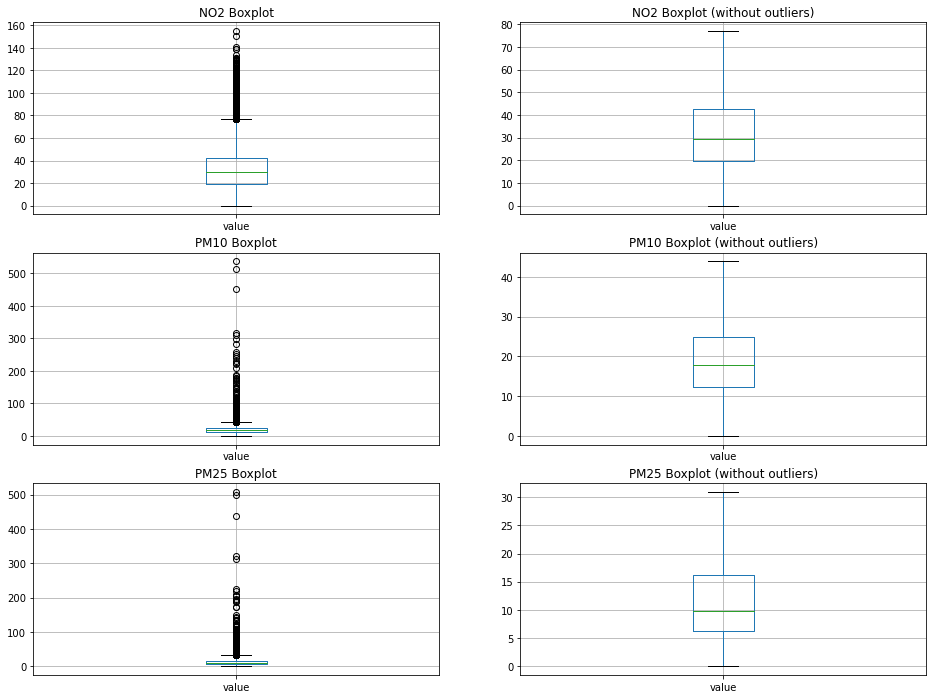

In [15]:
i = 1
plt.figure(figsize=(16,12))
for comp in aq.component_id.unique():
    plt.subplot(3,2,i)
    aq[aq['component_id'] == comp].boxplot(column='value')
    title = comp + ' Boxplot'
    plt.title(title)
    i+=1

    plt.subplot(3,2,i)
    aq[aq['component_id'] == comp].boxplot(column='value', showfliers=False) # sem outliers
    title = comp + ' Boxplot (without outliers)'
    plt.title(title)
    i+=1

We clearly see that there are a lot of extreme measurements, which indicate high levels of air pollution for the 3 pollutants.

It further reinforces the need to curb the existant pollution in Stadhouderskade, as these showings are very unhealthy for the people that frequent the street.

For purposes of readability, we present the plots for the measurements for December 2021.

In the appendix, you can find the plot for the whole period.

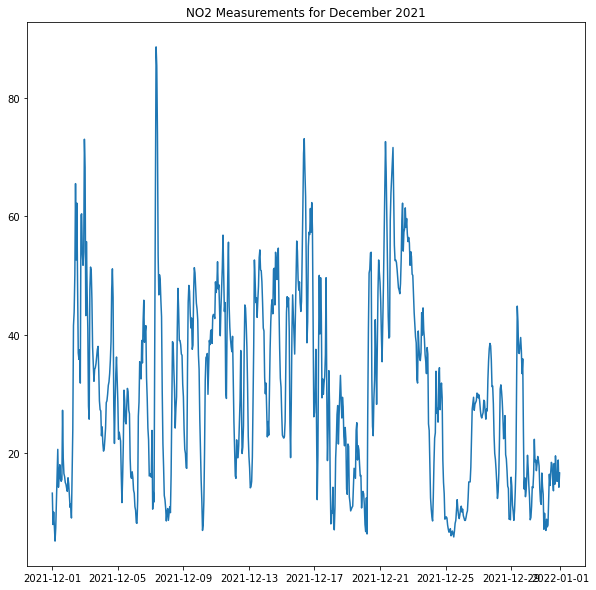

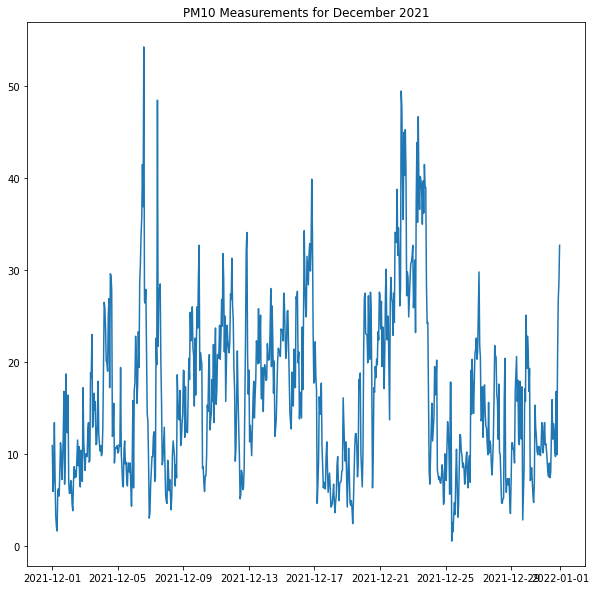

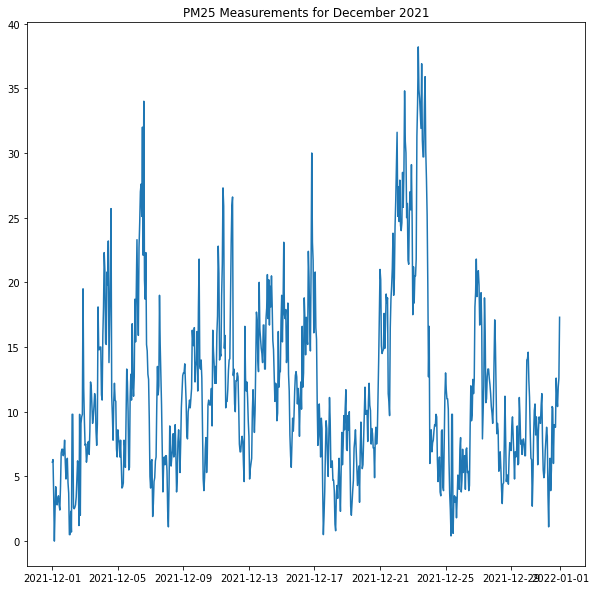

In [16]:
for comp in aq.component_id.unique():
    plt.figure(figsize=(10,10))
    plt.plot(aq[(aq['component_id'] == comp) & (aq['year'] == 2021) & (aq['month'] == 12)].timestamp_measured, aq[(aq['component_id'] == comp) & (aq['year'] == 2021) & (aq['month'] == 12)].value)
    title = comp + ' Measurements for December 2021'
    plt.title(title)
    plt.show()

As an example, we can see an increase on the days preceding Christmas, with a steep drop-off on the 25th.

Intuitively, we could say that the Christmas season usually leads people to more shopping, seeing the decorated streets, which may account for a bigger traffic.

As we are dealing with a time series, we also plotted the decomposition of the time series into trend, seasonality and residuals.

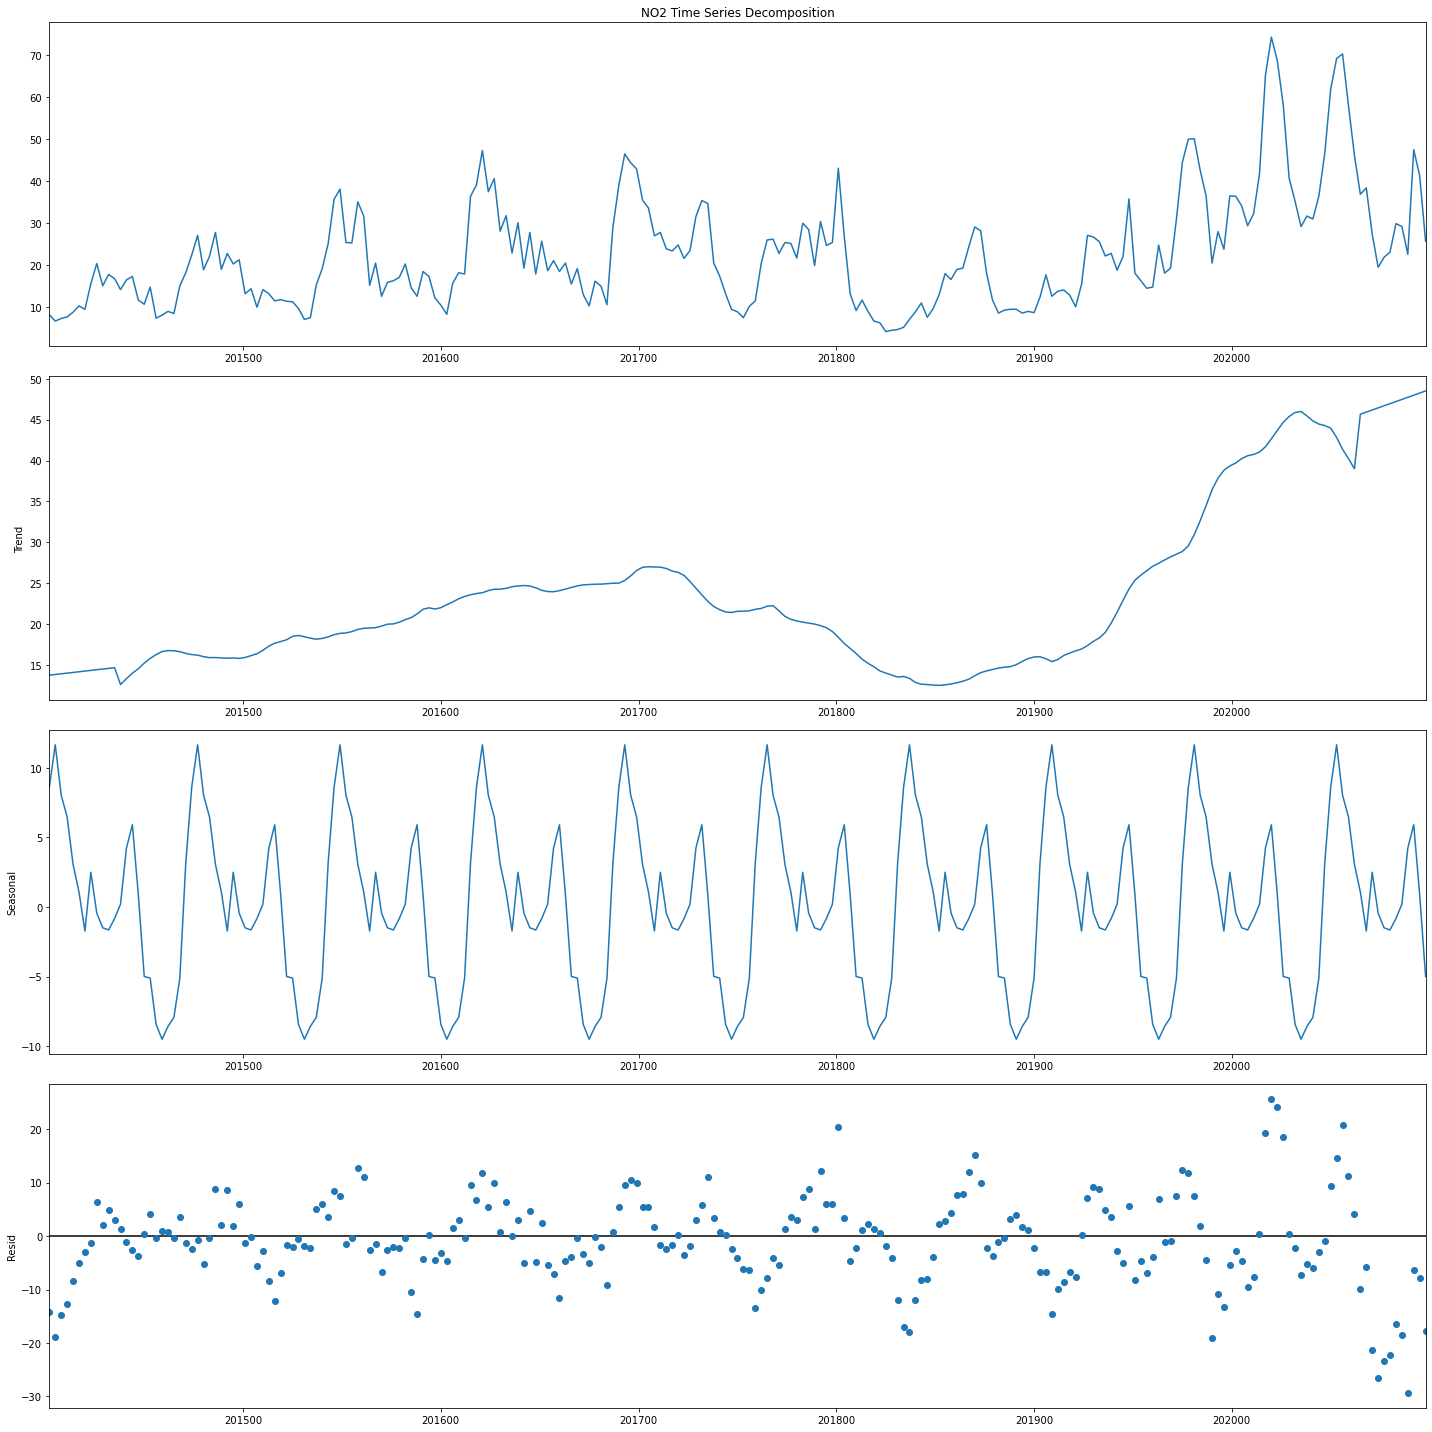

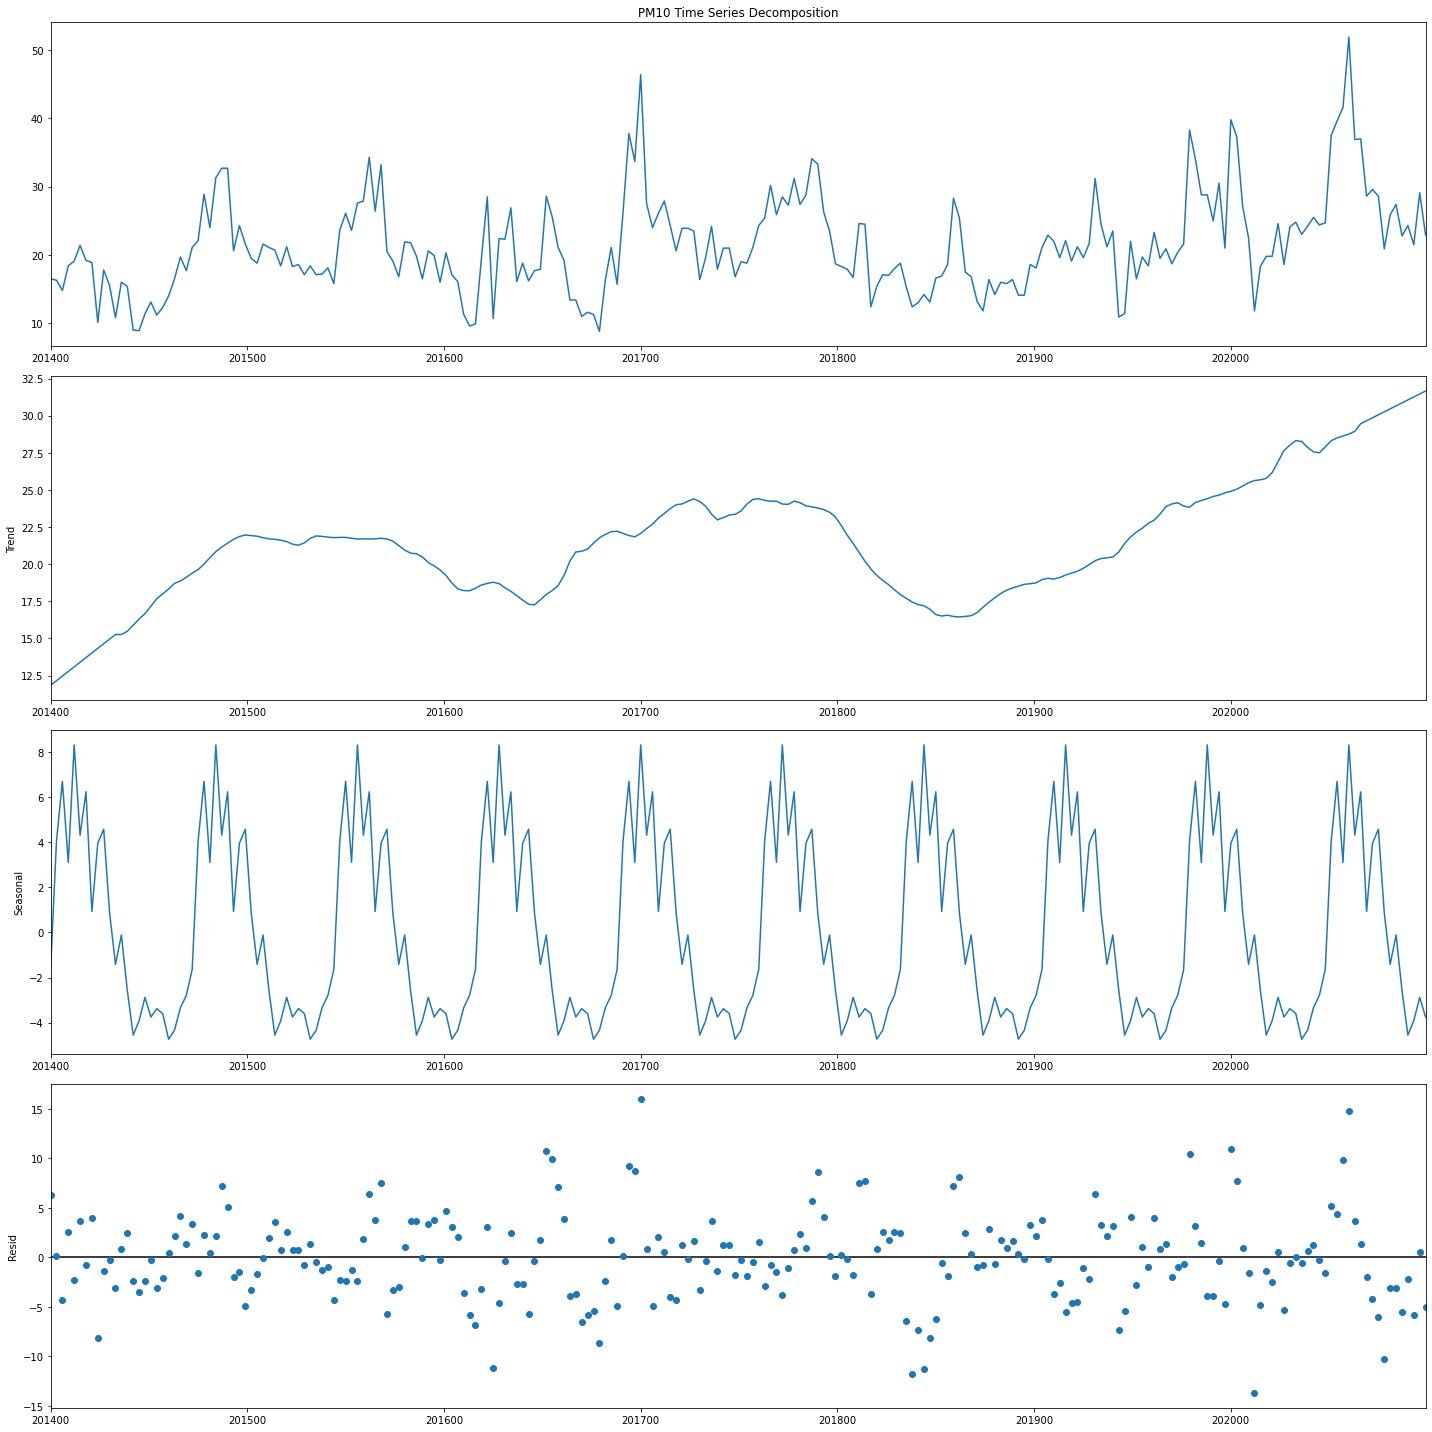

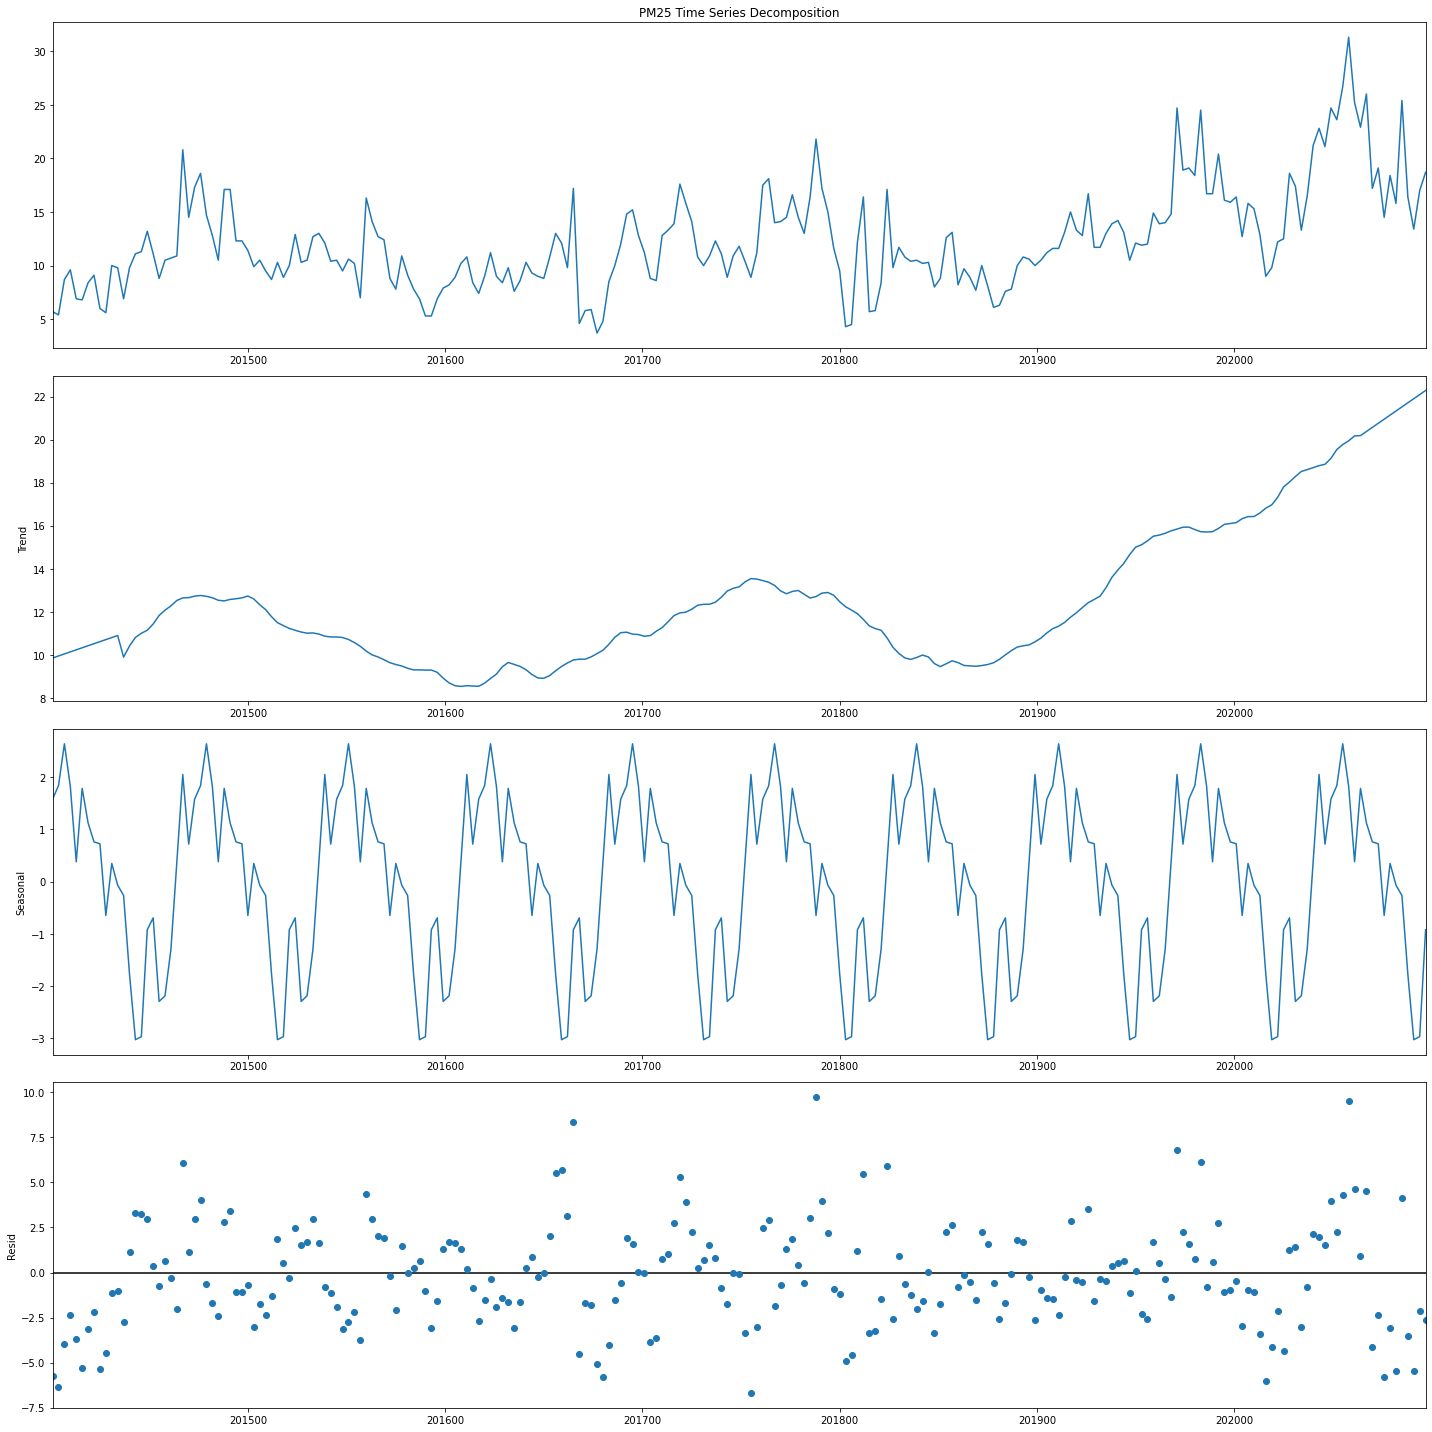

In [17]:
for comp in aq.component_id.unique():
    plt.rcParams["figure.figsize"] = (20,20)
    graph = aq[aq['component_id'] == comp]['value']
    graph.name = comp + ' Time Series Decomposition'
    result = seasonal_decompose(graph.loc['2014-01-01 00:00:00':'2021-12-31 23:00:00'], extrapolate_trend="freq", period=24)
    result.plot()

Starting in 2019, we see an upwards trend in pollution levels for the three pollutants.

We are also able to see the strong seasonality of pollution levels.

In [18]:
aq_pivot_year = aq.pivot_table(values = 'value', index = 'component_id', columns = 'year', aggfunc = ['median'], margins = True, fill_value = 0).round(2)
aq_pivot_year = aq_pivot_year.droplevel(0, axis=1)
aq_pivot_year

year          2014  2015  2016  2017  2018  2019  2020  2021  2022   All
component_id                                                            
NO2           35.0  34.6  33.6  32.1  30.8  28.1  21.2  21.2  23.0  29.6
PM10          20.7  18.7  18.3  17.7  18.4  17.1  15.6  16.3  18.4  17.8
PM25          12.1  10.2  10.2  10.4  10.6   7.5   7.7   9.6   9.6   9.8
All           21.8  19.6  19.7  18.8  19.0  16.9  13.8  14.7  16.8  17.9

Looking at the median values by year, we confirm what we see in the trend graph: a steady decrease until 2019. Starting in 2020, the median value increases.
    
2020 was the year when the Coronavirus outbreak took hold of the world, and isolation measures were implemented. Millions of people were stuck in their homes and discouraged of going outside, except for essential reasons (non-possibility of remote work, groceries shopping) so it's hard to pinpoint the reason for this increase. Since we know that traffic is the main reason for these pollutants, we'd expect the values would have decreased.

In [19]:
aq_pivot_month = aq.pivot_table(values = 'value', index = 'component_id', columns = 'month', aggfunc = ['median'], margins = True, fill_value = 0).round(2)
aq_pivot_month = aq_pivot_month.droplevel(0, axis=1)
aq_pivot_month

month            1     2     3      4     5      6     7     8     9    10  \
component_id                                                                 
NO2           34.3  33.3  30.0  28.20  25.0  24.05  23.4  26.0  31.0  32.2   
PM10          18.4  19.3  20.2  18.05  16.2  17.20  16.3  17.1  18.1  17.2   
PM25           9.8  10.3  10.8   9.60   9.2   9.60   8.7   8.8   9.9  10.1   
All           19.0  19.8  20.0  17.90  15.9  15.90  15.2  16.3  18.4  18.0   

month           11    12   All  
component_id                    
NO2           36.2  35.1  29.6  
PM10          18.0  18.9  17.8  
PM25          11.2  10.3   9.8  
All           20.3  19.7  17.9

Focusing on the median values by months, we see a parabole-shaped trend: if we start in january, the median value generally decreases until june, when it starts increasing again until december, completing the "circle" of the months of the year. Since winter is characterized by rainy and colder weather, people in Amsterdam may be discouraged of using their bikes and use
more cars for transportation, since it minimizes the effect of poor weather. In summer, with sunnier and amenable conditions, riding a bike or taking a walk is more pleasing, so emissions
decrease.

In [20]:
aq_pivot_season = aq.pivot_table(values = 'value', index = 'component_id', columns = 'season', aggfunc = ['median'], margins = True, fill_value = 0).round(2)
aq_pivot_season = aq_pivot_season.droplevel(0, axis=1)
aq_pivot_season

season        Autumn  Spring  Summer  Winter   All
component_id                                      
NO2             33.1    27.7   24.45    34.2  29.6
PM10            17.8    18.1   16.80    18.8  17.8
PM25            10.3     9.8    9.00    10.1   9.8
All             18.9    17.8   15.80    19.5  17.9

Grouping by season, we arrive at the same conclusion as before (month analysis), since seasons are groups of months.

In [21]:
aq_pivot_weekend = aq.pivot_table(values = 'value', index = 'component_id', columns = 'weekend', aggfunc = ['median'], margins = True, fill_value = 0).round(2)
aq_pivot_weekend = aq_pivot_weekend.droplevel(0, axis=1)
aq_pivot_weekend

weekend          0     1   All
component_id                  
NO2           31.2  25.9  29.6
PM10          18.1  17.2  17.8
PM25           9.8   9.8   9.8
All           18.2  17.0  17.9

Regarding the week, we can see that for NO2, there is a big drop-off on polution levels on weekends (we can presume there is not an affluence as big as during the week, so the effects of rush hour are less pronounced, because there won't be a schedule to maintain/follow).

For PM10, there is a difference of 1 $\mu $g/$m^3$ in the median pollution level, while for PM25 there are no differences in the median pollution level.

Next, we will check the correlation between features, focusing on the correlation between our target variable and the dependent variables.

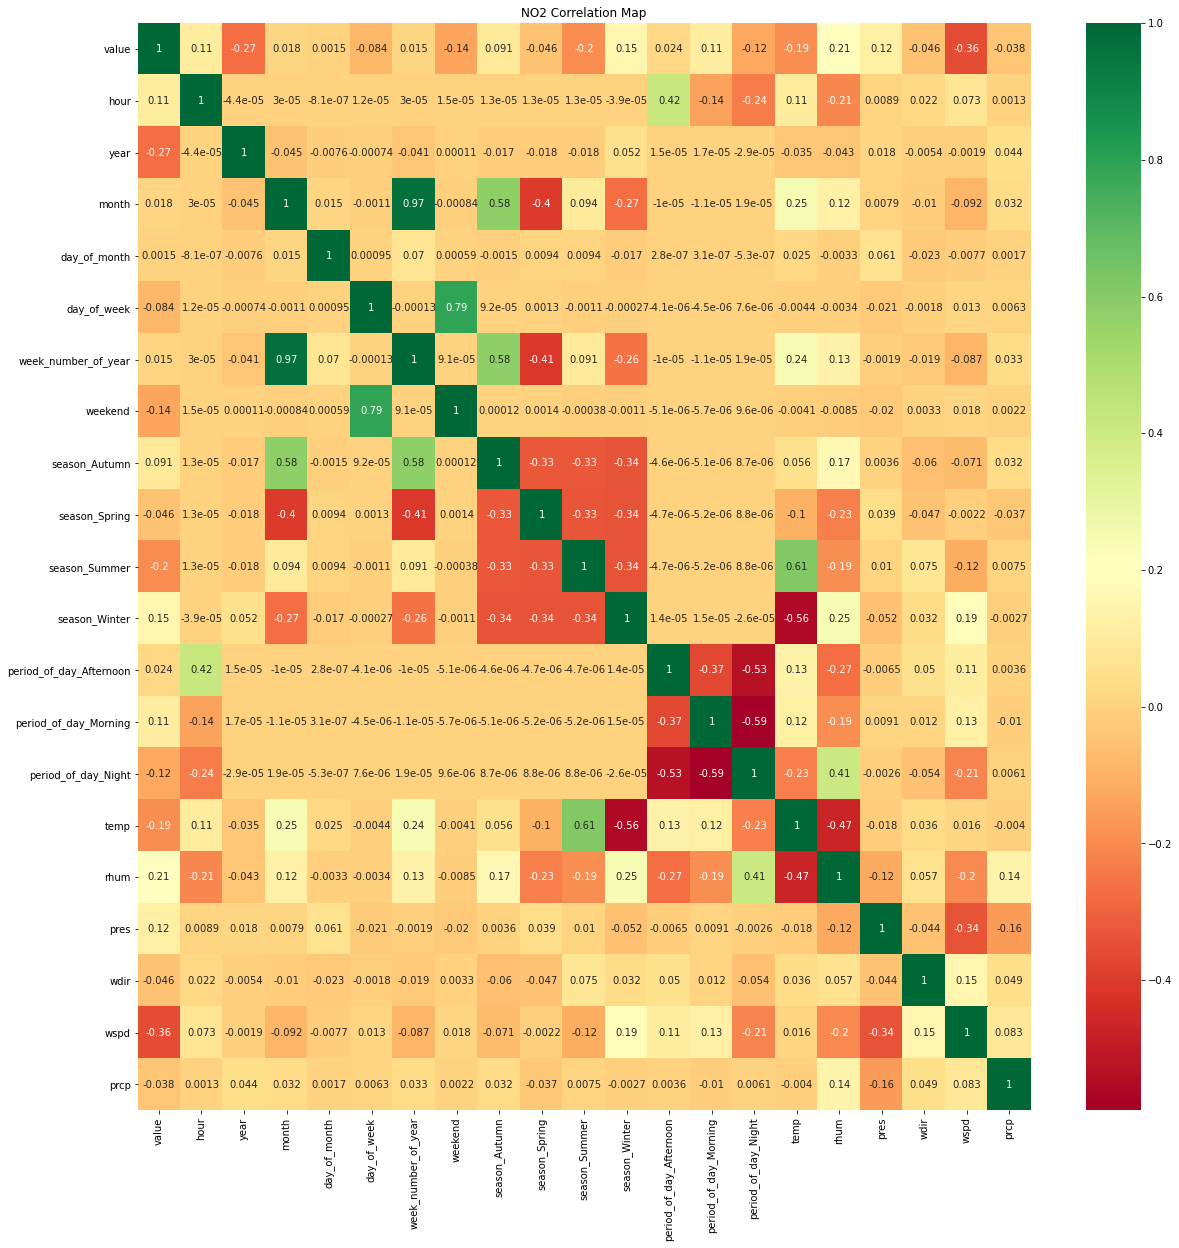

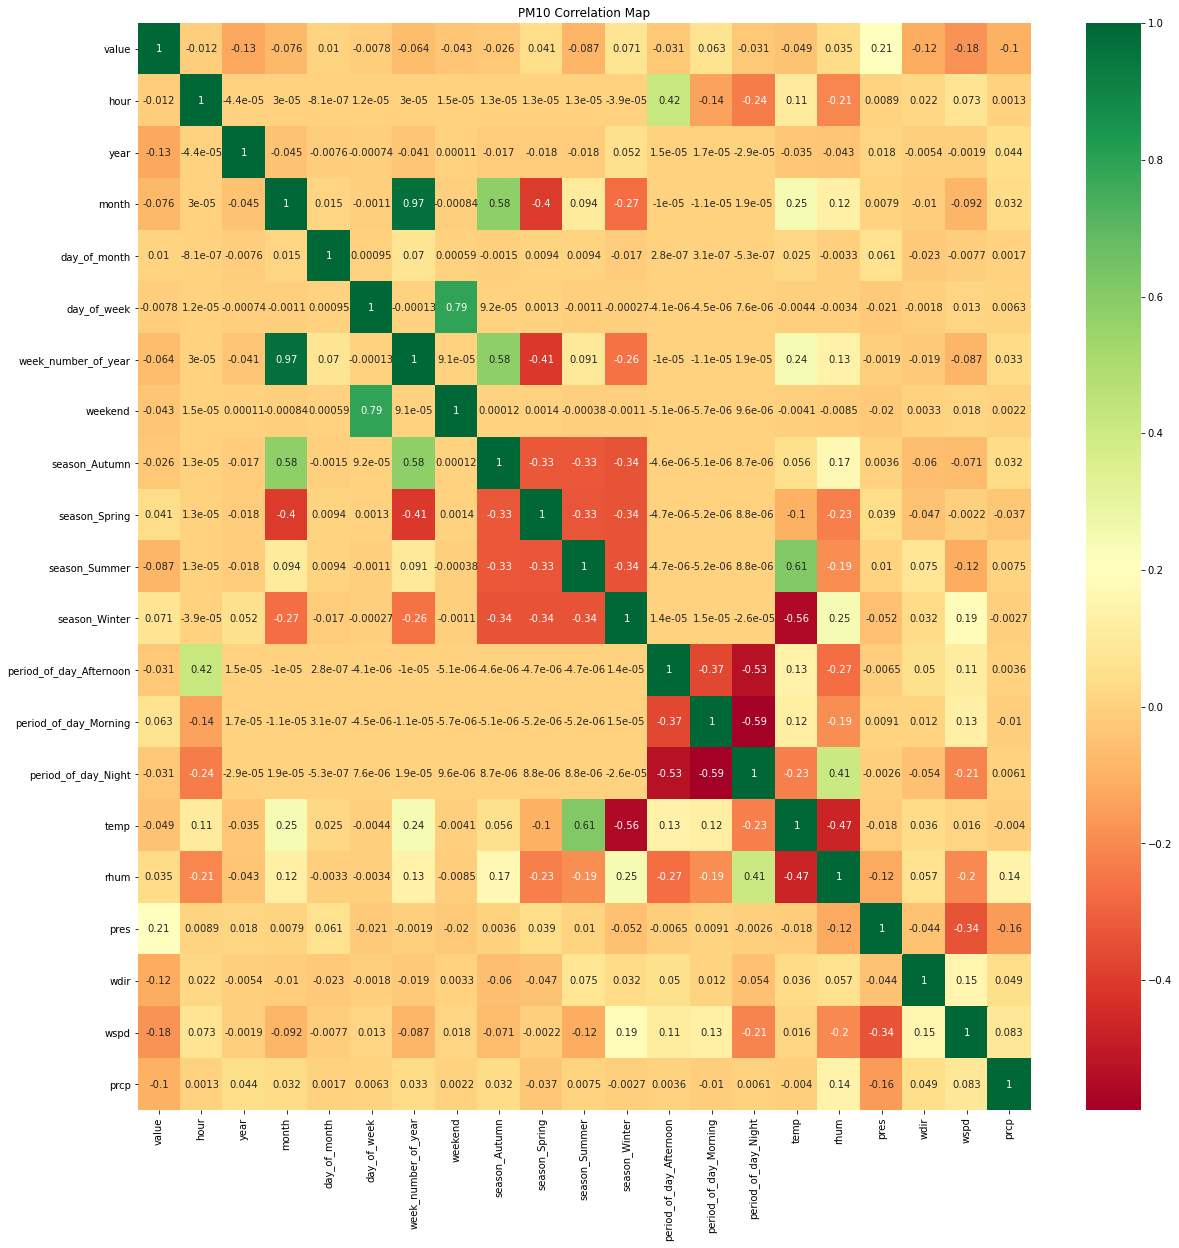

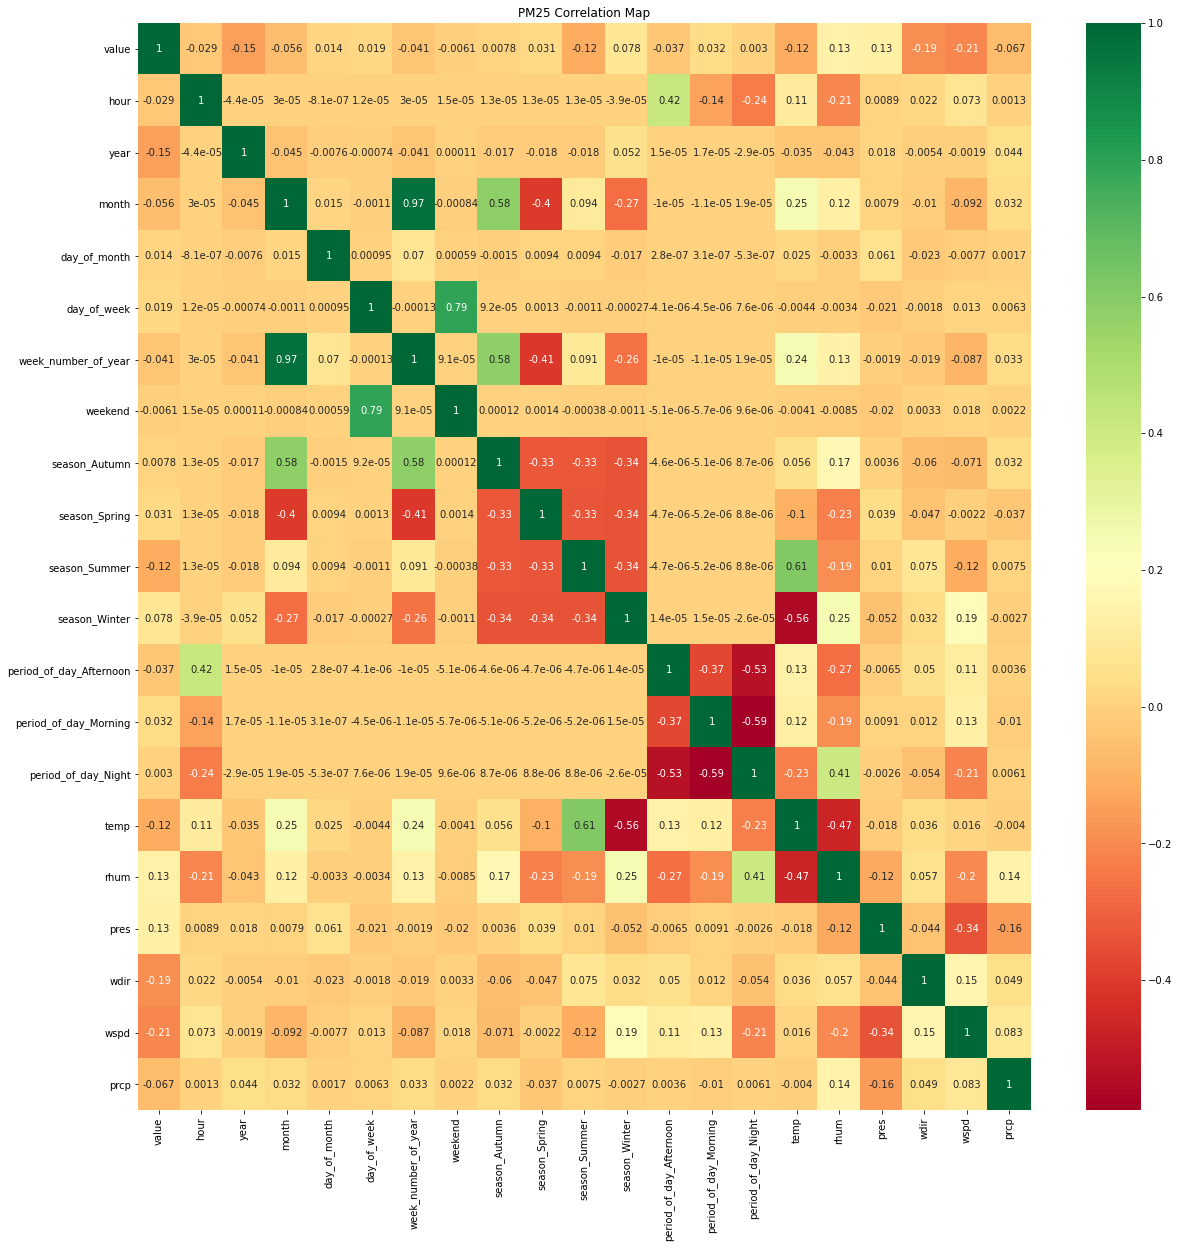

In [22]:
for comp in aq.component_id.unique():
    corr_heatmap = aq[aq['component_id'] == comp][['value', 'hour', 'year', 'month', 'day_of_month', 'day_of_week', 'week_number_of_year',
                                                   'weekend', 'season_Autumn', 'season_Spring', 'season_Summer', 'season_Winter', 'period_of_day_Afternoon',
                                                   'period_of_day_Morning', 'period_of_day_Night', 'temp', 'rhum', 'pres', 'wdir', 'wspd', 'prcp']]
    plt.figure(figsize=(20,20))
    plt.title(comp + ' Correlation Map')
    sns.heatmap(corr_heatmap.corr(), cmap='RdYlGn', annot=True)
    plt.show()

Analyzing the correlation of the variables in the dataset to the pollution value measured, we highlight the strongest correlations:

NO2:
 - Negative correlation with year, wind speed, temperature, the Summer season, the Night period and weekend.
 - Positive correlation with the Winter season, hour, the Morning period, pressure and humidity
 
PM10:
 - Negative correlation with year, precipitation, wind speed and direction
 - Positive correlation with pressure
 
PM25:
 - Negative correlation with year, wind speed and direction, temperature and the Summer season
 - Positive correlation with pressure and humidity
 
Although the correlation values are not high, in general we observe the same behaviour regarding the features and our dependent variable.

We conclude that even though we have 3 pollutants with different chemical properties, they are affected in the same way by weather and time and some of the findings are in agreement with the conclusions drawn previously.

We also conducted some analysis on a couple of time series characteristics like:
 - Stationarity
 - Autocorrelation
 - Seasonality

That we included in the appendix.

### Modelling

For modelling purposes, we will not analyze the dataset as is but also group it by day and component_id, and create aggregate measures (mean, standard deviation, median, maximum and minimum of the values of the pollutants).

That way, we want to see if we get better results predicting the mean value for a pollutant in a day, rather than hourly.

In total, we built 9 models (one for each of the 3 pollutants): SARIMA, Holt-Winters and LightGBM. We will only present the LightGBM model, as it outperformed the other two models.

At the end, we show the results obtained for the Mean Absolute Percentage Error.

##### LightGBM

The next cell contains all the functions used in the development of the LightGBM model.

We will hide it to save space.

In [23]:
## Functions for LightGBM

def transform_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Does some data engineering on the input data:
    - Changing type of weather variables: some for float and weather direction to categorical
    - Creation of day_of_month and day_of_week variables
    - Sort dataset and delete some unecessary variables

    Args:
        df (pd.DataFrame): input data

    Returns:
        (pd.DataFrame): data with applied transformations.
    """

    # turn wind direction into a categorical column
    compassSector = np.array(["N", "NNE", "NE", "ENE", "E", "ESE", "SE", "SSE", "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW", "N"])
    df['wdir'] = compassSector[(df['wdir']/ 22.5).astype('int')]
    dummies_wdir = pd.get_dummies(df['wdir'], prefix="wdir")
    df = pd.concat([df, dummies_wdir], axis=1).drop(['wdir'], axis=1)

    df = df.sort_values(by=['timestamp_measured'])
    df = df.drop(['timestamp_measured', 'time', 'season', 'period_of_day'], axis=1)

    return df

def create_aggr_daily_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Creates a dataframe aggregated by day. 

    Args:
        df (pd.DataFrame): input data
    
    Returns:
        pd.DataFrame: data agrregated by day
    """
    df_aggr_day = df.groupby(['component_id', 'date']).agg(
        min_temp = pd.NamedAgg(column='temp', aggfunc=min), 
        max_temp= pd.NamedAgg(column='temp', aggfunc=max), 
        mean_temp = pd.NamedAgg(column='temp', aggfunc=pd.Series.mean), 
        
        min_rhum = pd.NamedAgg(column='rhum', aggfunc=min), 
        max_rhum= pd.NamedAgg(column='rhum', aggfunc=max), 
        mean_rhum = pd.NamedAgg(column='rhum', aggfunc=pd.Series.mean),

        total_pres = pd.NamedAgg(column='pres', aggfunc=max),
        
        total_prcp = pd.NamedAgg(column='prcp', aggfunc=sum),

        total_wdir_E = pd.NamedAgg(column='wdir_E', aggfunc=sum),
        total_wdir_ENE = pd.NamedAgg(column='wdir_ENE', aggfunc=sum),
        total_wdir_ESE = pd.NamedAgg(column='wdir_ESE', aggfunc=sum),
        total_wdir_N = pd.NamedAgg(column='wdir_N', aggfunc=sum),
        total_wdir_NE = pd.NamedAgg(column='wdir_NE', aggfunc=sum),
        total_wdir_NNE = pd.NamedAgg(column='wdir_NNE', aggfunc=sum),
        total_wdir_NNW = pd.NamedAgg(column='wdir_NNW', aggfunc=sum),
        total_wdir_NW = pd.NamedAgg(column='wdir_NW', aggfunc=sum),
        total_wdir_S = pd.NamedAgg(column='wdir_S', aggfunc=sum),
        total_wdir_SE = pd.NamedAgg(column='wdir_SE', aggfunc=sum),
        total_wdir_SSE = pd.NamedAgg(column='wdir_SSE', aggfunc=sum),
        total_wdir_SSW = pd.NamedAgg(column='wdir_SSW', aggfunc=sum),
        total_wdir_SW = pd.NamedAgg(column='wdir_SW', aggfunc=sum),
        total_wdir_W = pd.NamedAgg(column='wdir_W', aggfunc=sum),
        total_wdir_WNW = pd.NamedAgg(column='wdir_WNW', aggfunc=sum),
        total_wdir_WSW = pd.NamedAgg(column='wdir_WSW', aggfunc=sum),

        min_wspd = pd.NamedAgg(column='wspd', aggfunc=min), 
        max_wspd = pd.NamedAgg(column='wspd', aggfunc=max), 
        mean_wspd = pd.NamedAgg(column='wspd', aggfunc=pd.Series.mean),

        year = pd.NamedAgg(column='year', aggfunc=max), 
        month = pd.NamedAgg(column='month', aggfunc=max), 
        week_number_of_year = pd.NamedAgg(column='week_number_of_year', aggfunc=max),
        weekend = pd.NamedAgg(column='weekend', aggfunc=max),
        day_of_month = pd.NamedAgg(column='day_of_month', aggfunc=max),
        day_of_week = pd.NamedAgg(column='day_of_week', aggfunc=max),

        season_Autumn = pd.NamedAgg(column='season_Autumn', aggfunc=max),
        season_Spring = pd.NamedAgg(column='season_Spring', aggfunc=max),
        season_Summer = pd.NamedAgg(column='season_Summer', aggfunc=max),
        season_Winter = pd.NamedAgg(column='season_Winter', aggfunc=max),

        min_value = pd.NamedAgg(column='value', aggfunc=min), 
        max_value= pd.NamedAgg(column='value', aggfunc=max), 
        mean_value = pd.NamedAgg(column='value', aggfunc=pd.Series.mean),
        std_value = pd.NamedAgg(column='value', aggfunc=pd.Series.std)
        ).reset_index().sort_values('date')
        
    return df_aggr_day

def shifted_features(df: pd.DataFrame, variable: str) -> pd.DataFrame:
    """
    Shifts time-relevant columns by 5 hours(hourly)/days(daily) to allow the algorithm to learn time dependencies.

    Args:
        df (pd.DataFrame): input data for each component
        variable (str): time-relevant column

    Returns:
        pd.DataFrame: input data for each component + time based features
    """
    df_new = pd.DataFrame()
    for i in range(1, 6):
        df[variable + "_shifted-" + str(i)] = df[variable].shift(i)

    df_new = pd.concat([df_new, df])

    return df_new

def roll_mean_features(df: pd.DataFrame, 
                       windows: list, 
                       variable: str) -> pd.DataFrame:
    """
    Creates moving averages for specified time intervals. 
    This function takes the number of time given as window parameter and takes 
    the average of the values, but one of the values is the value on this specific observation. 
    In order to eliminate today's affect on moving average values, we will take 1 shift. 

    Args:
        df (pd.DataFrame): input data for each component 
        windows (list): time intervals for which we want to create the moving averages.
        variable (str): time-relevant column
    
    Returns:
        pd.DataFrame: input data for each component + time based features
    """
    df = df.copy()
    
    for window in windows:
        df['value_roll_mean_' + str(window)] = df[variable].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).mean())
    
    return df

def ewm_features(df: pd.DataFrame, 
                 alphas: list, 
                 lags: list, 
                 variable: str) -> pd.DataFrame:
    """
    To have a better prediction, while computing the average value, the values should not be equally weighted.
    Values will be shifted by the given lags (number of hours/days to be used for calculation) and the values 
    will be weighted (using the alpha value) and the mean weighted value is obtained. 
    Alpha is a parameter that is between 0 and 1, when close to 1 the near past will be weighted more 
    and oppositely when close to 0 the far past will be weighted more.

    Args:
        df (pd.DataFrame): input data for each component
        alphas (list): values by which we want to weight our values
        lags (list): time-interval for which we want to shift our data. 
        variable (str): time-relevant column
    
    Returns:
        pd.DataFrame: input data for each component + time based features
    """
    df = df.copy()
    for alpha in alphas:
        for lag in lags:
            df['value_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                df[variable]. \
                    transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return df

def split_data(df: pd.DataFrame) -> tuple:
    """splits data into train, test, val based on groupby run_id to avoid info leakage

    Args:
        df (pd.DataFrame): data

    Returns:
        tuple: data splitted into train, val, test
    """
    train = df.loc[(df['date'] <= "2020-06-30"), :]
    val = df.loc[(df['date'] > "2020-06-30") & (df['date'] <= "2020-12-31"), :]
    test = df.loc[(df['date'] > "2020-12-31"), :]

    return train, val, test

def transform_data_for_comp(df: pd.DataFrame, 
                            comp: str, 
                            df_type: str) -> tuple:
    """
    Prepares the data so that the model can train for each component. 
    
    Args:
        df (pd.DataFrame): input data
        comp (str): model component (PM10, PM25, etc.)  
        df_type (str): indicates if it's the hourly or daily model 
        
    Returns:
        tuple: data splitted into train, val, test
    """
    if df_type == "hourly":
        windows = [24, 168, 720, 2160]
        alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
        lags = [24, 168, 720, 2160]
        target_variable = "value" 
    else:
        windows = [7, 30, 90]
        alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
        lags = [7, 30, 90]
        target_variable = "mean_value"

    df = df[df['component_id'] == comp].drop(['component_id'], axis=1)

    df = shifted_features(df, target_variable)
    # 24 => ultimo dia | 168 => ultimos 7 dias | 720 => ultimos 30 dias (+- ultimo mes) | 2160 => ultimos 90 dias (+/-3 meses)
    df = roll_mean_features(df, windows, target_variable)

    df = ewm_features(df, alphas, lags, target_variable)

    train, val, test = split_data(df)

    return train, val, test

def train_model_lgb(X_train: pd.DataFrame, 
                    Y_train: pd.DataFrame, 
                    X_val: pd.DataFrame, 
                    Y_val: pd.DataFrame) -> lgb.Booster:
    """
    Trains and validates an LightGBM Model with early stopping.

    Args:
        X_train (pd.DataFrame): train data
        Y_train (pd.DataFrame): train target
        X_val (pd.DataFrame): val data (for early stopping)
        Y_val (pd.DataFrame): val target (for early stopping)

    Returns:
        lgb.Booster: fitted model
    """
    cols = X_train.columns.to_list()
    lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
    lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

    lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 15000,
              'early_stopping_rounds': 200,
              'nthread': -1}

    model = lgb.train(lgb_params,
                    lgbtrain,
                    valid_sets=[lgbval],
                    verbose_eval=200)
    
    return model

def eval_model(model: lgb.Booster, 
               X_test: pd.DataFrame, 
               Y_test: pd.DataFrame) -> list:
    """
    Evaluates model of a dimension with regards to test data.

    Args:
        model (lgb.Booster): model to be evalued
        X_test (pd.DataFrame): test data
        Y_test (pd.DataFrame): test target
    
    Returns:
        list: list of eval metrics
    """
    preds = model.predict(X_test)

    return [mean_squared_error(preds, Y_test), 
        mean_absolute_percentage_error(preds, Y_test) * 100,
        preds]

# def save_error_results(metrics: list, df_type: str) -> None:
#     """
#     Saves eval metrics into a a file.

#     Args:
#         metrics (list): list of eval metrics
#         df_type (str): indicates if it's the hourly or daily model 
#     """
#     f = open('results/' + df_type + '/' + df_type + "_predsLGBM_errors.txt", "a")
#     f.write("----------------------------------- \n")
#     f.write("COMPONENT: " + comp + "\n" + "MSE: " + str(metrics[0]) + "\n" + "MAPE: " + str(metrics[1]) + "\n")
#     f.write("----------------------------------- \n")
#     f.close()

def plot_lgb_importances(model: lgb.Booster, comp: str, df_type: str) -> None:
    """
    Plots the most important features of the model.

    Args:
        model (lgb.Booster): trained model
        comp (str): model component (PM10, PM25, etc.)  
        df_type (str): indicates if it's the hourly or daily model 
    """
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
    plt.xlabel("Gain")
    plt.ylabel('Features')
    plt.title(f'Feature importance for {df_type} model trained - {comp}', fontsize=20)
    plt.tight_layout()
    #plt.savefig('results/' + df_type + '/' + df_type + '_featureImportance_' + comp)

def plot_images(model: lgb.Booster,
                preds: list, 
                Y_test: pd.DataFrame, 
                comp: str, 
                df_type: str) -> None:
    """
    Plot some graphs for the test set for visual inspection.

    Args:
        model: 
        preds (list): preds obtained from evaluating
        Y_test (pd.DataFrame): test target
        comp (str): model component (PM10, PM25, etc.)  
        df_type (str): indicates if it's the hourly or daily model  
    """
    if df_type == "hourly":
        one_day = 24
        x_label = "Hours"
    else:
        one_day = 2
        x_label = "Days"

    # image 1 - looking to all data
    plt.figure(figsize=(24,8))
    sns.lineplot(x=Y_test.reset_index(drop=True).index, y=preds)
    sns.lineplot(x=Y_test.reset_index(drop=True).index, y=Y_test)
    plt.legend(["Predictions", "True"])
    plt.xlabel(x_label)
    plt.ylabel('Values')
    plt.title(f'Comparison between true and predicted values for all the test data - {comp}', fontsize=20)
    #plt.savefig('results/' + df_type + '/' + df_type + '_predsLGBM_' + comp) 

    # image 2 - looking at just one day
    plt.figure(figsize=(24,8))
    sns.lineplot(x=X_test.reset_index(drop=True)[0:one_day].index, y=preds[0:one_day])
    sns.lineplot(x=X_test.reset_index(drop=True)[0:one_day].index, y=Y_test[0:one_day])
    plt.legend(["Predictions", "True"])
    plt.xlabel(x_label)
    plt.ylabel('Values')
    plt.title(f'Comparison between true and predicted values for one specific day - {comp}', fontsize=20)
    #plt.savefig('results/' + df_type + '/' + df_type + '_predsLGBM_' + comp + "_1day") 

    # image 3 - feature importance
    plot_lgb_importances(model, comp, df_type)

    # image 4 -
    plt.figure(figsize=(24,8))
    plt.scatter(Y_test, preds, c="steelblue")
    plt.plot( [0,80],[0,80], c='dimgrey' )
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.title(f'Comparison between true and predicted values - {comp}', fontsize=20)
    #plt.savefig('results/' + df_type + '/' + df_type + '_scatterPlot_' + comp)

First we build a model for the Hourly forecast.

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009740 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[200]	valid_0's l1: 4.15011
[400]	valid_0's l1: 3.83382
[600]	valid_0's l1: 3.73995
[800]	valid_0's l1: 3.69925
[1000]	valid_0's l1: 3.68273
[1200]	valid_0's l1: 3.67332
[1400]	valid_0's l1: 3.66952
[1600]	valid_0's l1: 3.66767
[1800]	valid_0's l1: 3.66525
[2000]	valid_0's l1: 3.65998
[2200]	valid_0's l1: 3.65461
[2400]	valid_0's l1: 3.64934
[2600]	valid_0's l1: 3.64828
[2800]	valid_0's l1: 3.64777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3000]	valid_0's l1: 3.64622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[2902]	valid_0's l1: 3.64453
MAPE NO2 equal to 16.714410034166242


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008919 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[200]	valid_0's l1: 3.16469
[400]	valid_0's l1: 3.06621
[600]	valid_0's l1: 3.04799
[800]	valid_0's l1: 3.03986
[1000]	valid_0's l1: 3.04411
Early stopping, best iteration is:
[818]	valid_0's l1: 3.0392
MAPE PM10 equal to 19.77925852352787


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008975 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[200]	valid_0's l1: 2.05771
[400]	valid_0's l1: 2.00883
[600]	valid_0's l1: 1.98658
[800]	valid_0's l1: 1.97185
[1000]	valid_0's l1: 1.9655
[1200]	valid_0's l1: 1.96236
[1400]	valid_0's l1: 1.95847
[1600]	valid_0's l1: 1.9563
[1800]	valid_0's l1: 1.95436
[2000]	valid_0's l1: 1.95551
Early stopping, best iteration is:
[1847]	valid_0's l1: 1.95377
MAPE PM25 equal to 20.377558175380585


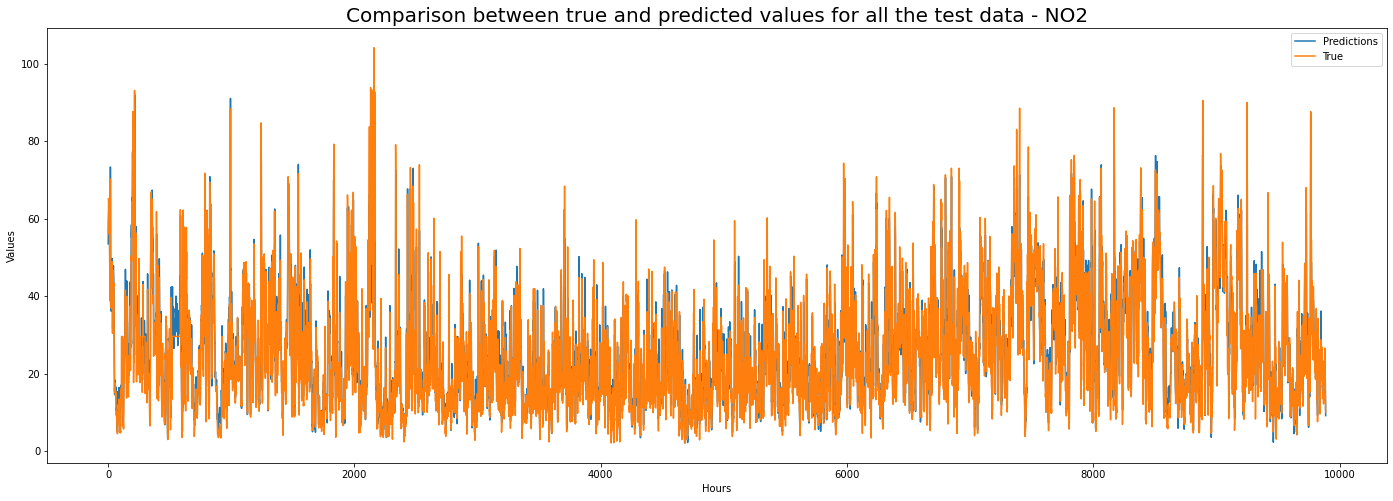

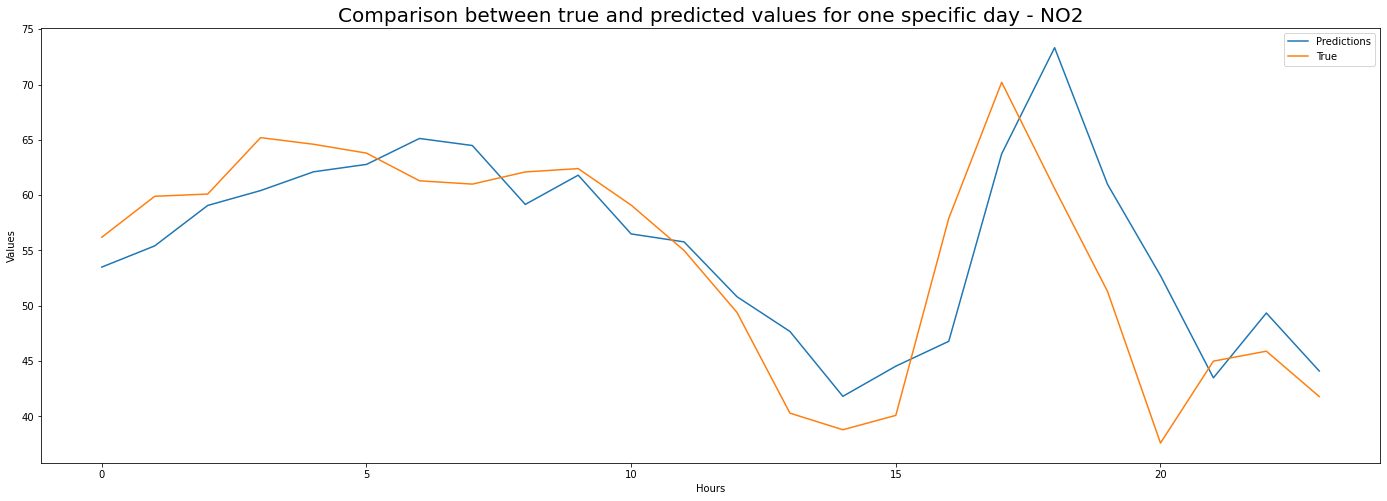

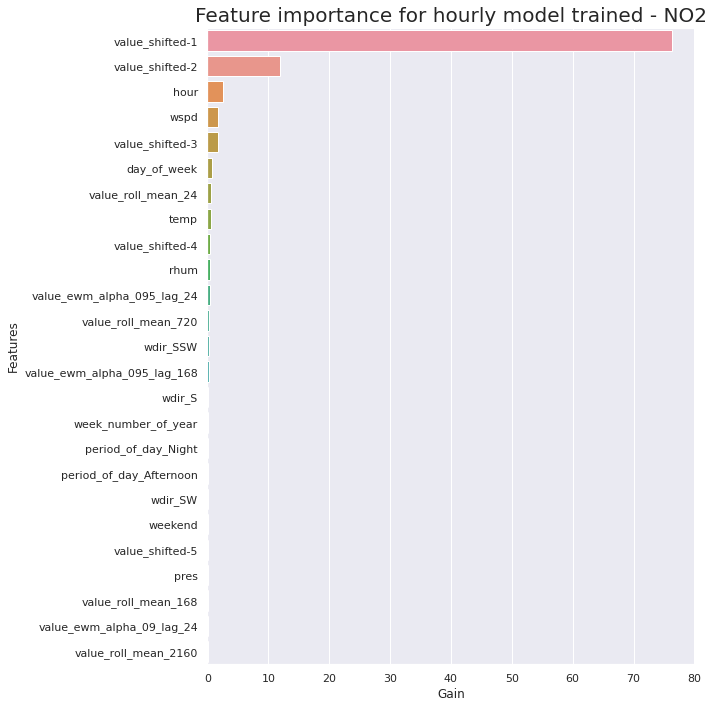

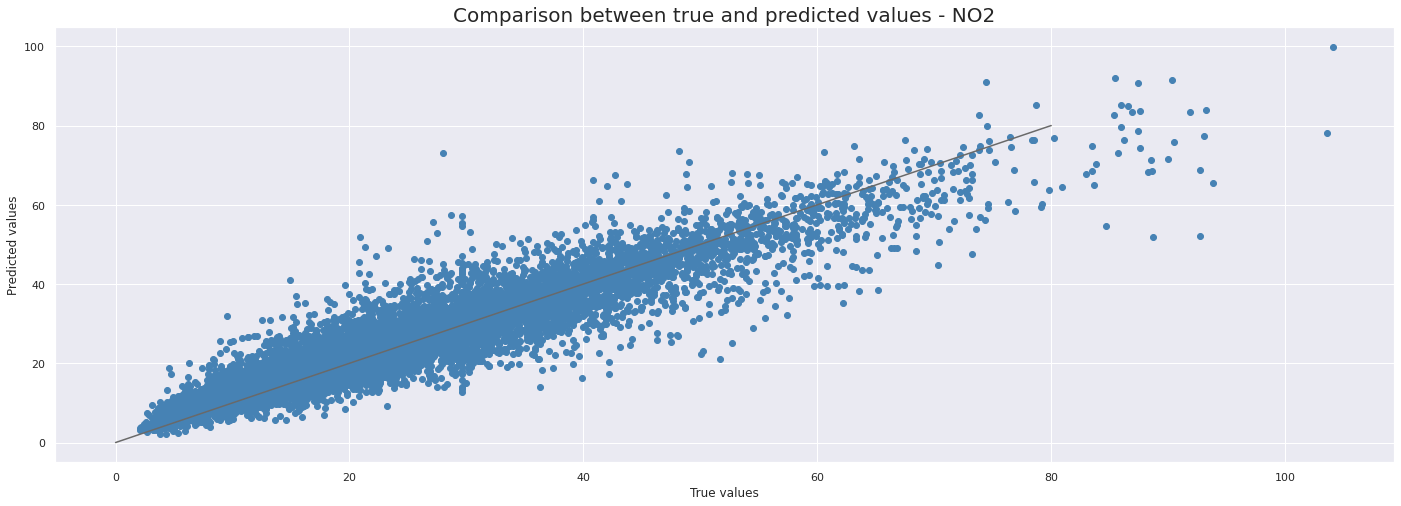

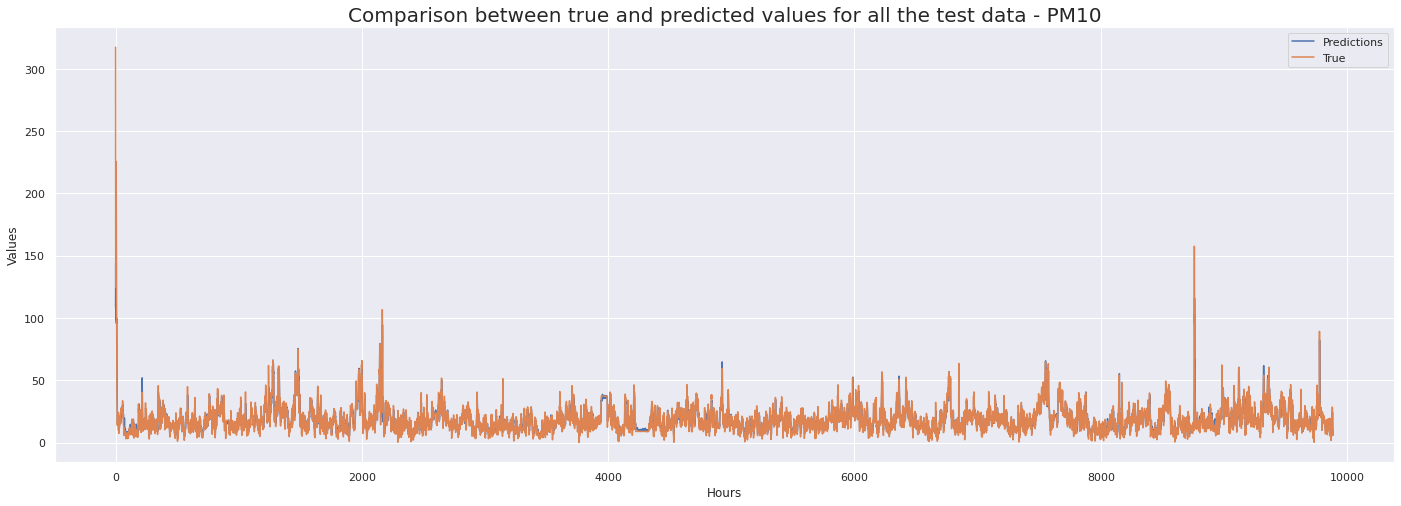

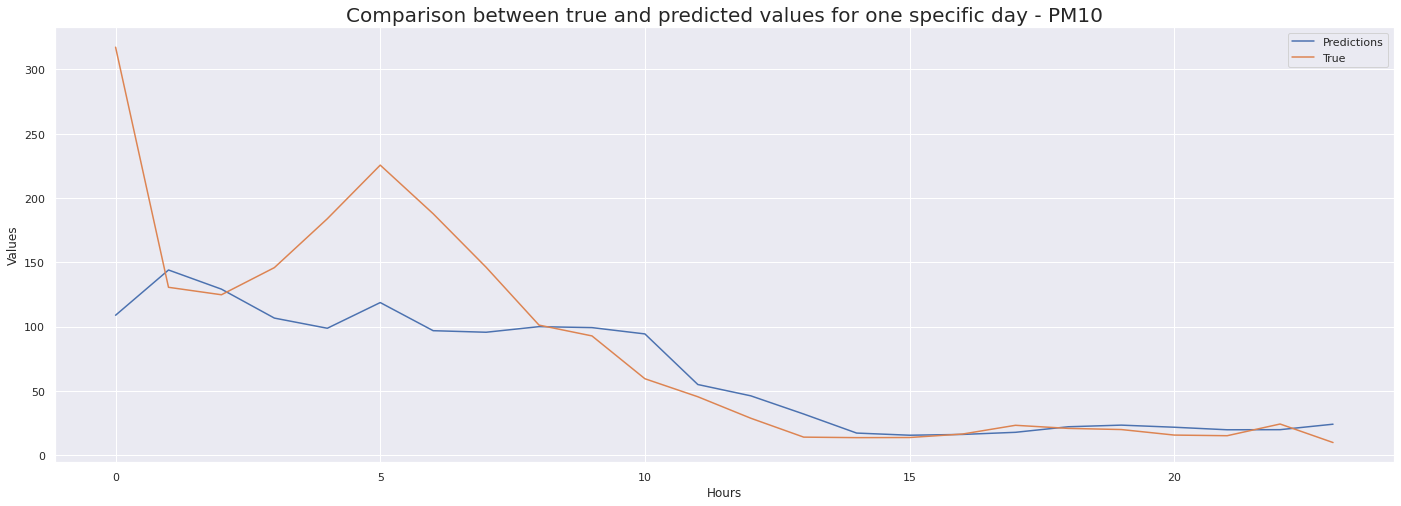

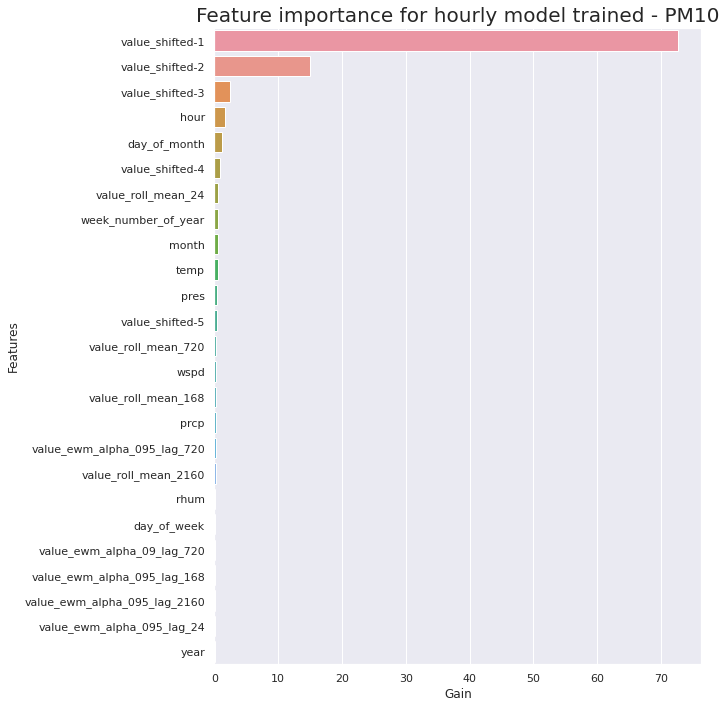

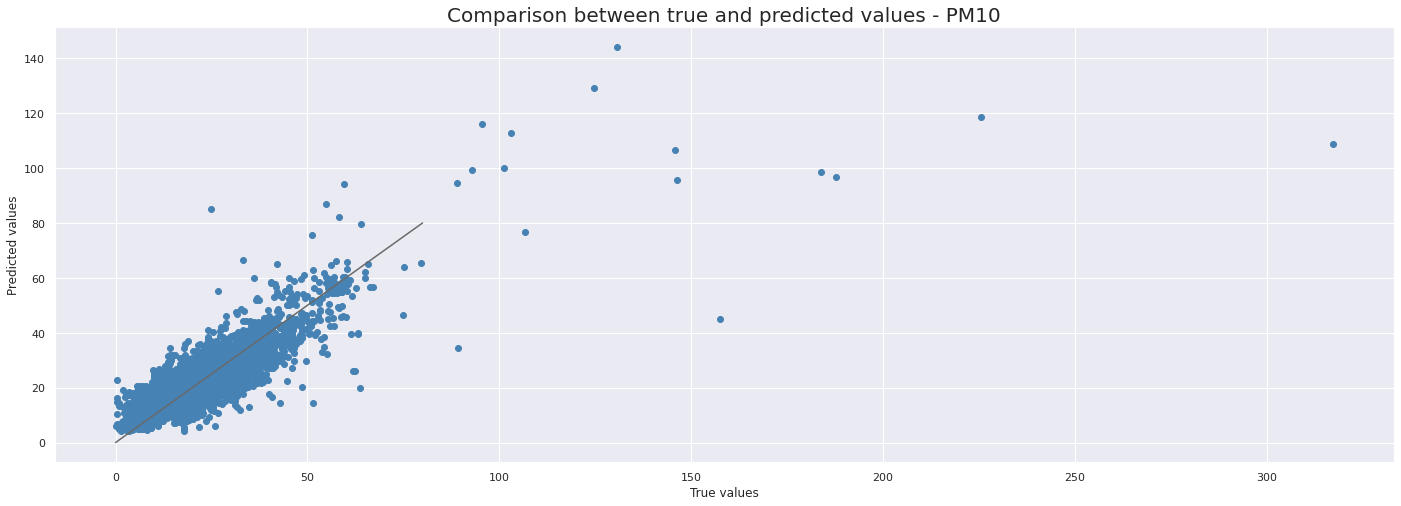

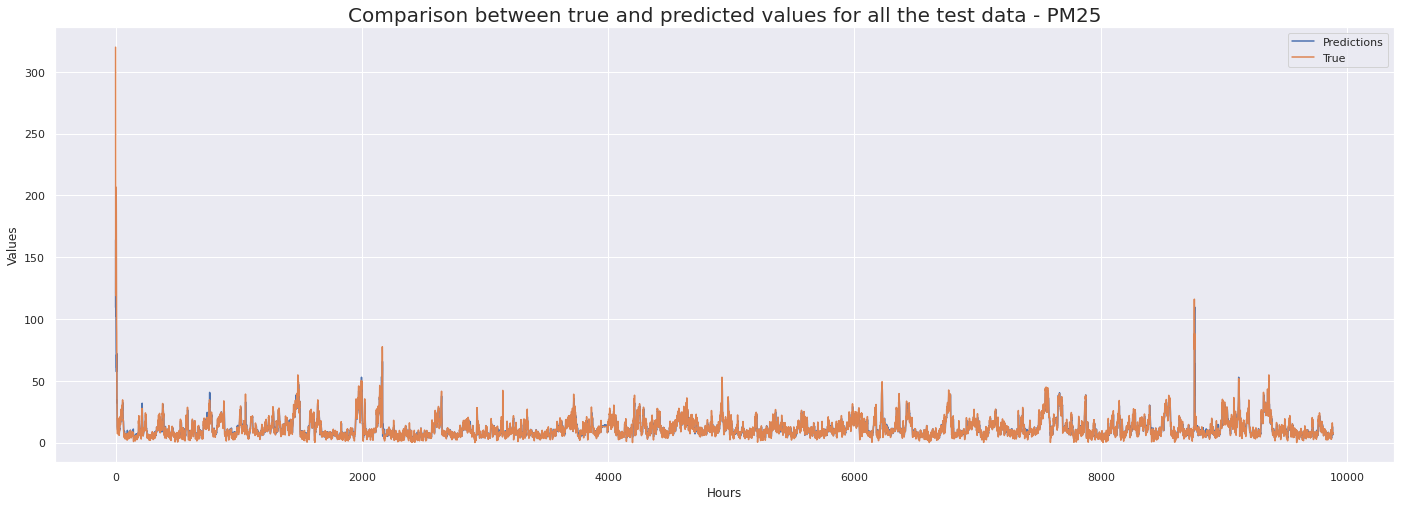

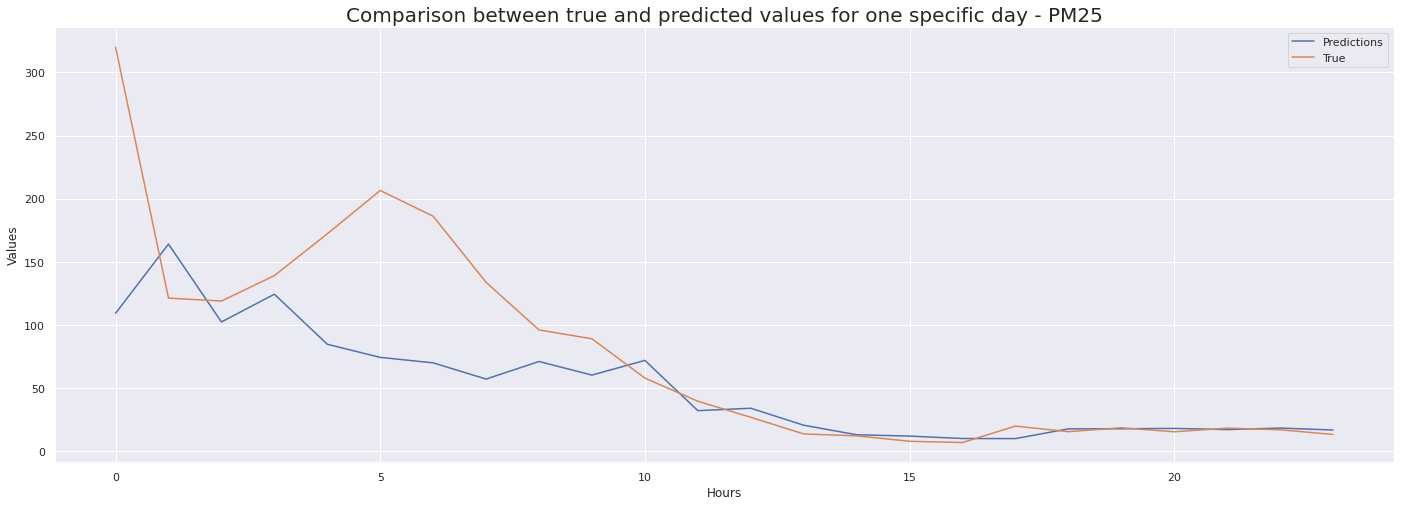

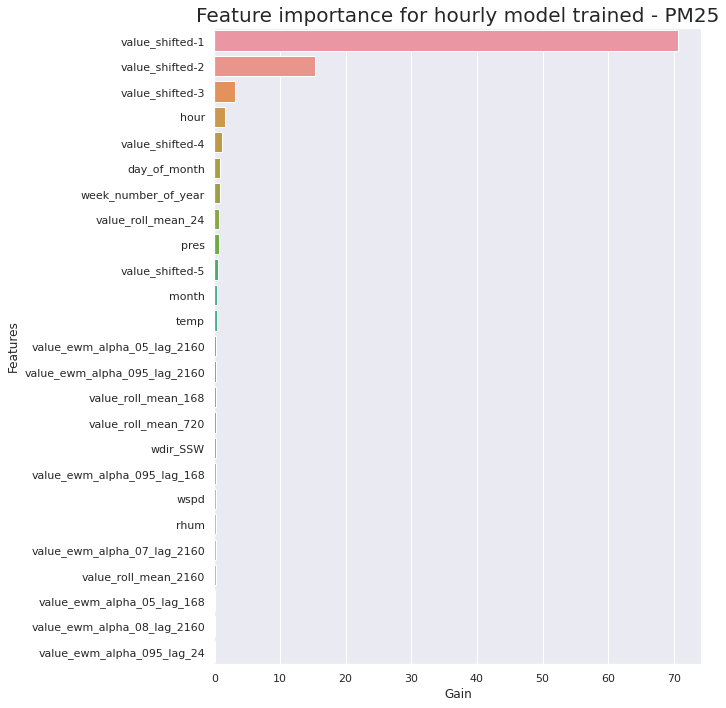

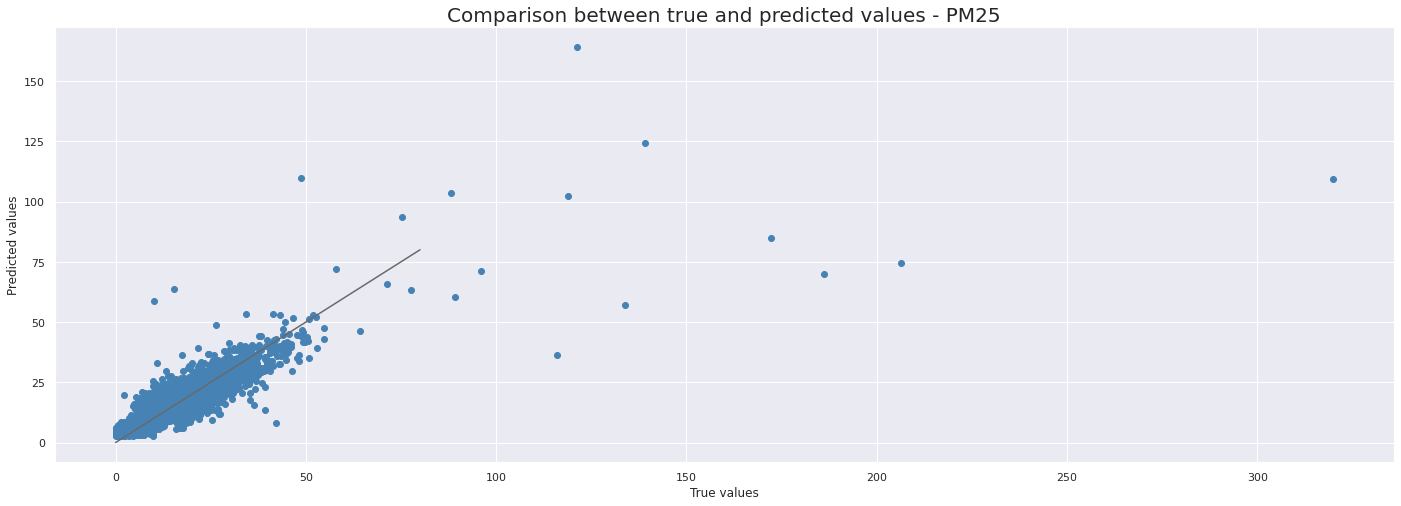

In [24]:
components = ["NO2", "PM10", "PM25"]
df_type = "hourly"

aq_hourly = aq.copy()

# data engineering
df = transform_data(aq_hourly)

# train/evaluate
for comp in components:
    train, val, test = transform_data_for_comp(df, comp, df_type)

    Y_train = train['value']
    X_train = train.drop(['value', 'date'], axis=1)
    Y_val = val['value']
    X_val = val.drop(['value', 'date'], axis=1)
    Y_test = test['value']
    X_test = test.drop(['value', 'date'], axis=1)

    model = train_model_lgb(X_train, Y_train, X_val, Y_val)
    metrics = eval_model(model, X_test, Y_test)
    #pd.DataFrame(metrics[2], columns=['predictions']).to_csv(f'results_{df_type}_predsLGBM_{comp}.csv', sep=",")
    
    #save_error_results(metrics, df_type)
    
    print('MAPE', comp, 'equal to', metrics[1])
    
    plot_images(model, metrics[2], Y_test, comp, df_type)

Analyzing the feature importance for the 3 models, we see that the most important features are the hour of the day and the values prior.

This is something that, when dealing with data of this nature, the literature agrees on: the preceding values are very important to understand the behavior of the next future step. Intuitively, we know that is true and that, unless for very exceptional reasons, we should not have massive and sudden variations.

Then we build another model for the Daily forecast.

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[200]	valid_0's l1: 4.91214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	valid_0's l1: 4.33208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002069 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[200]	valid_0's l1: 3.34485
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002045 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[200]	valid_0's l1: 2.57193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

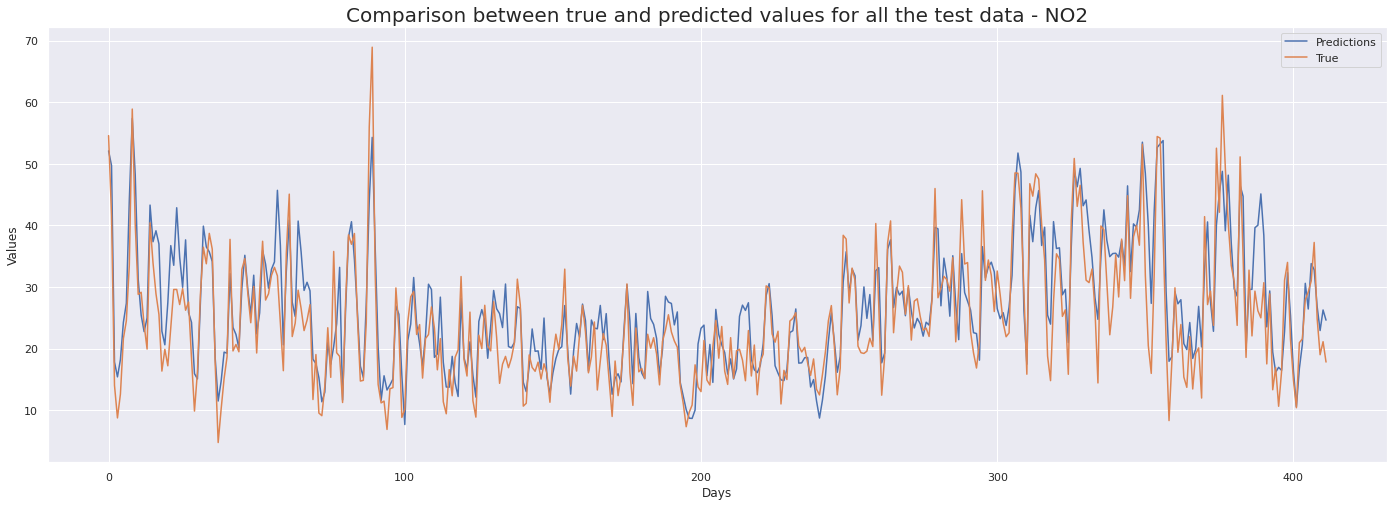

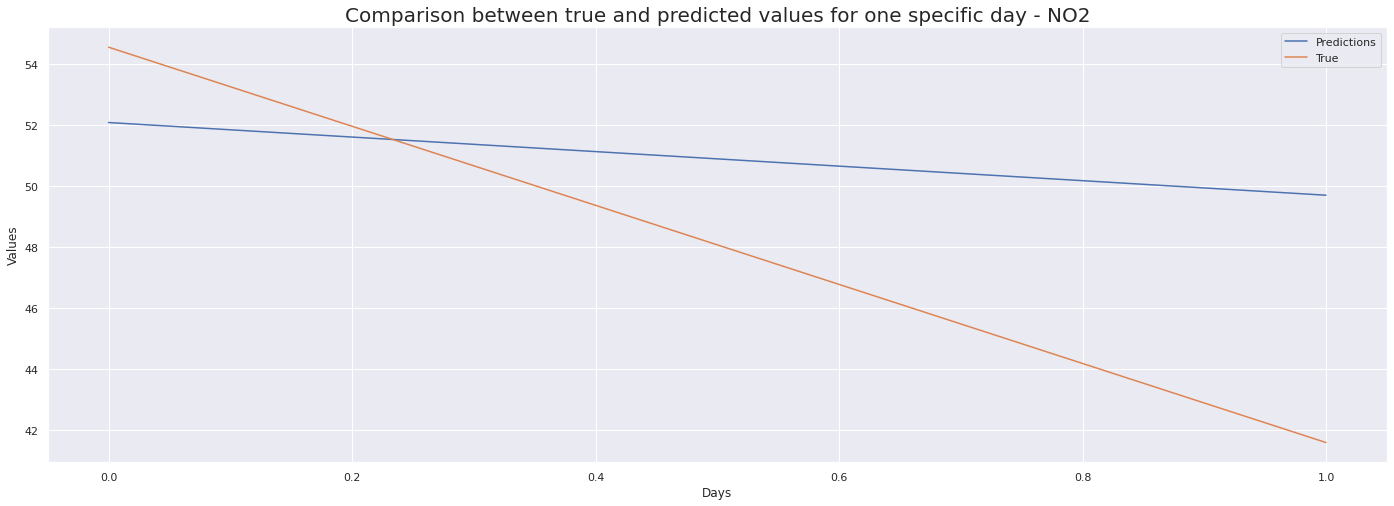

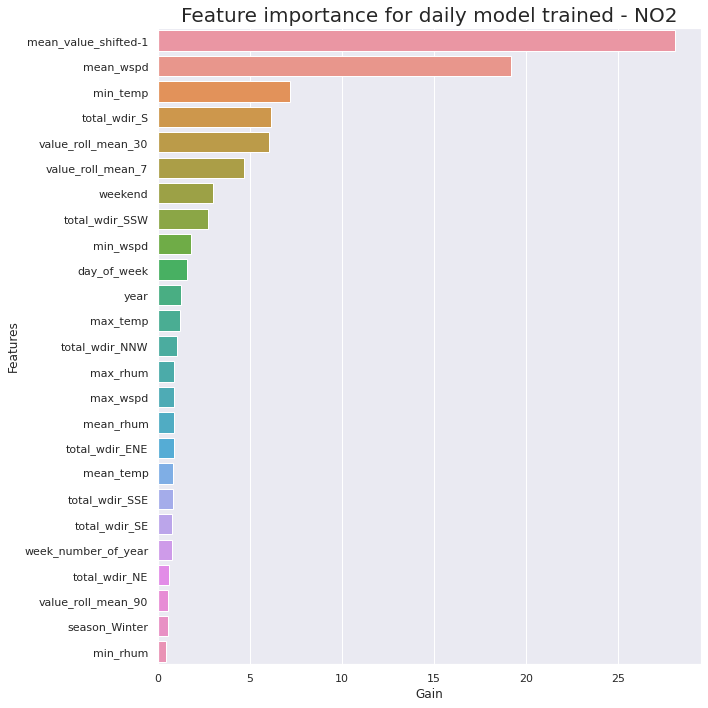

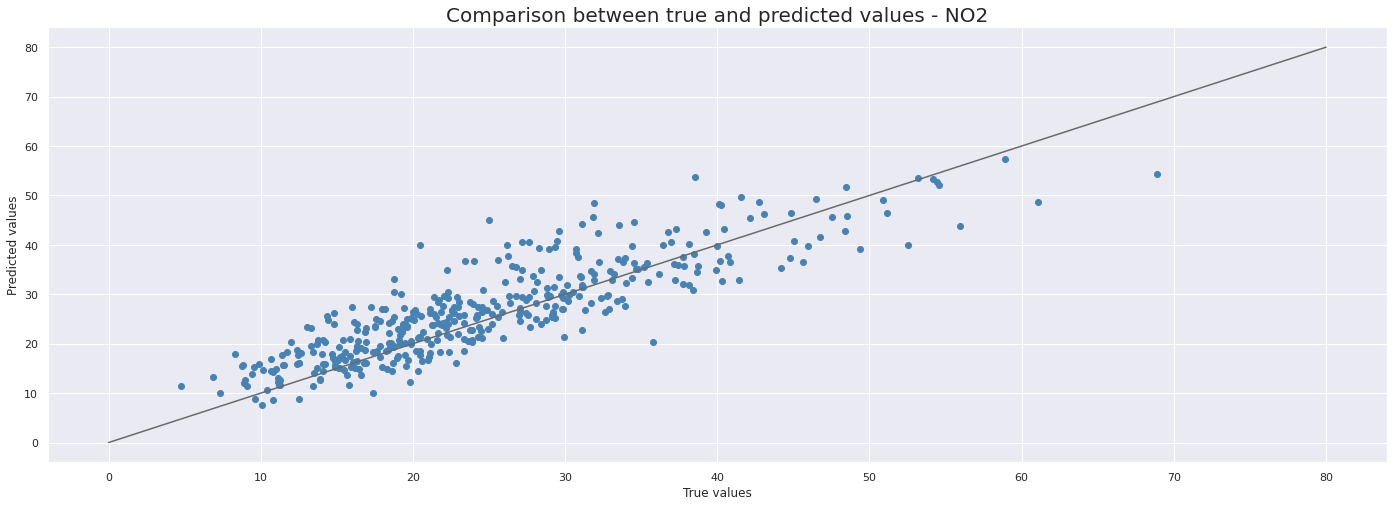

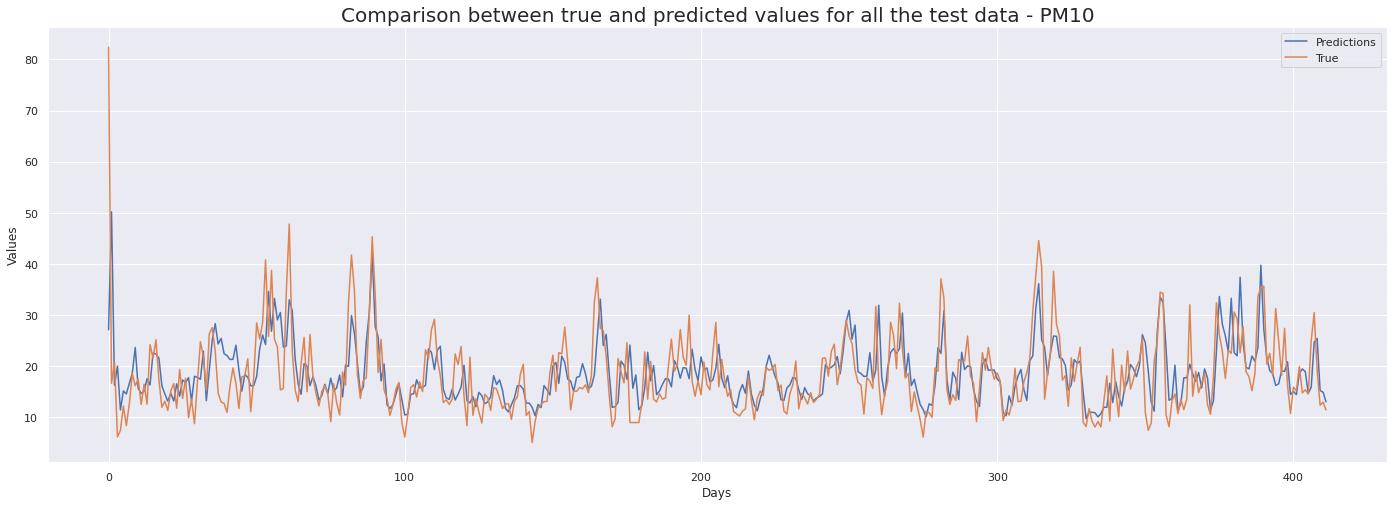

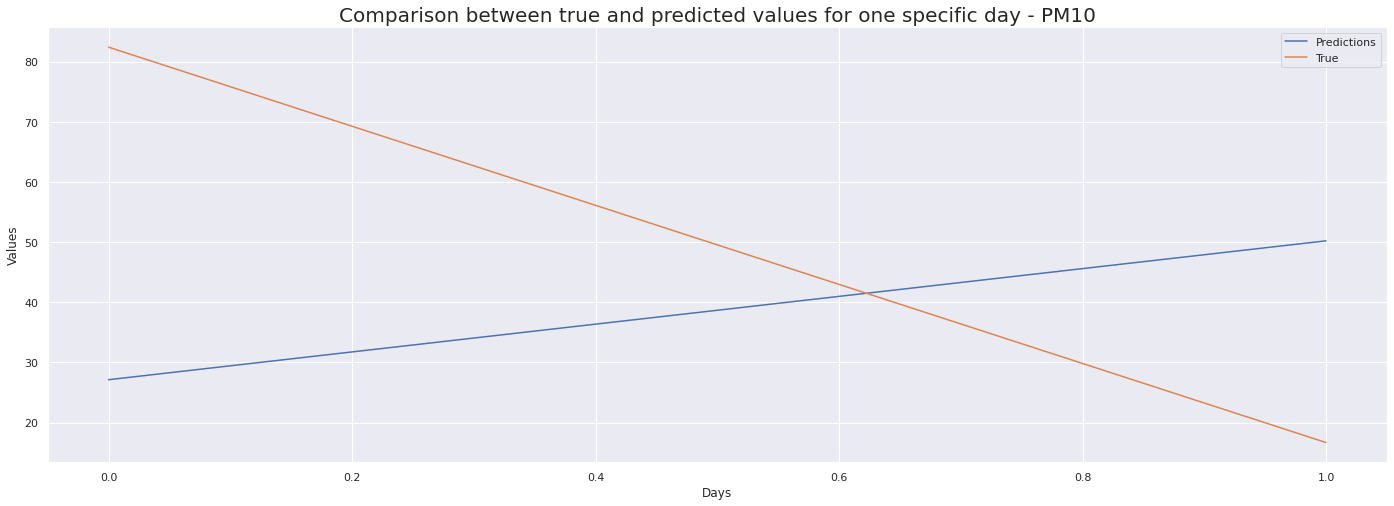

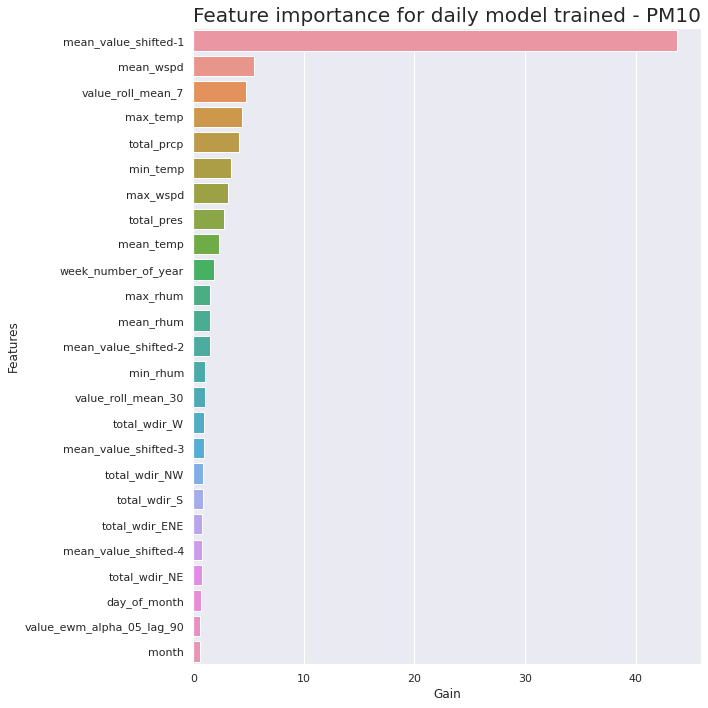

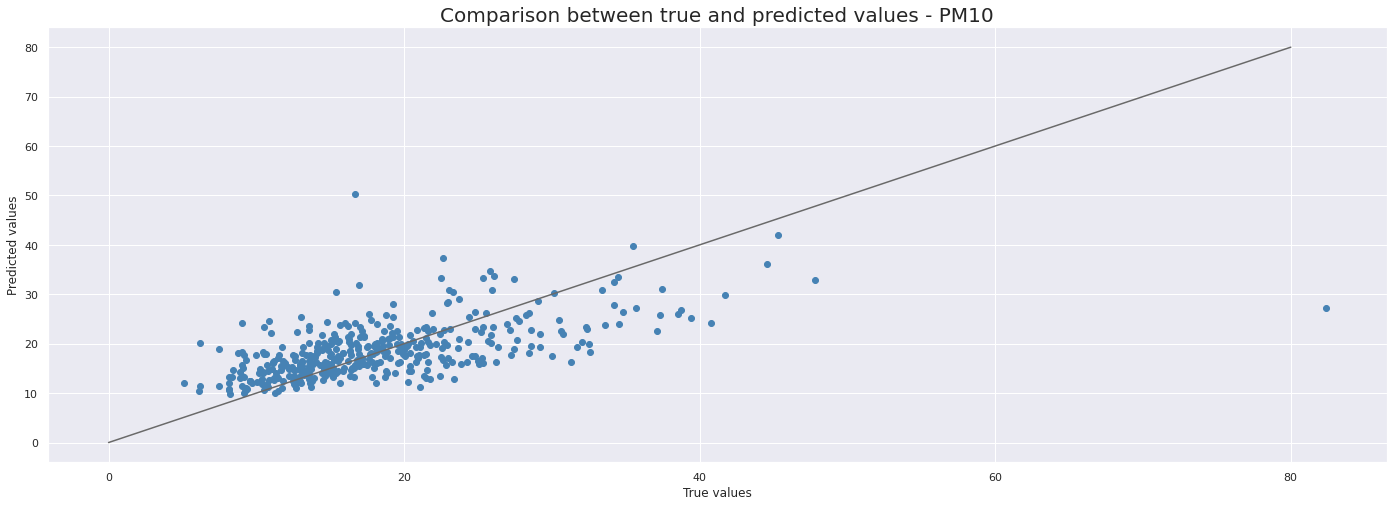

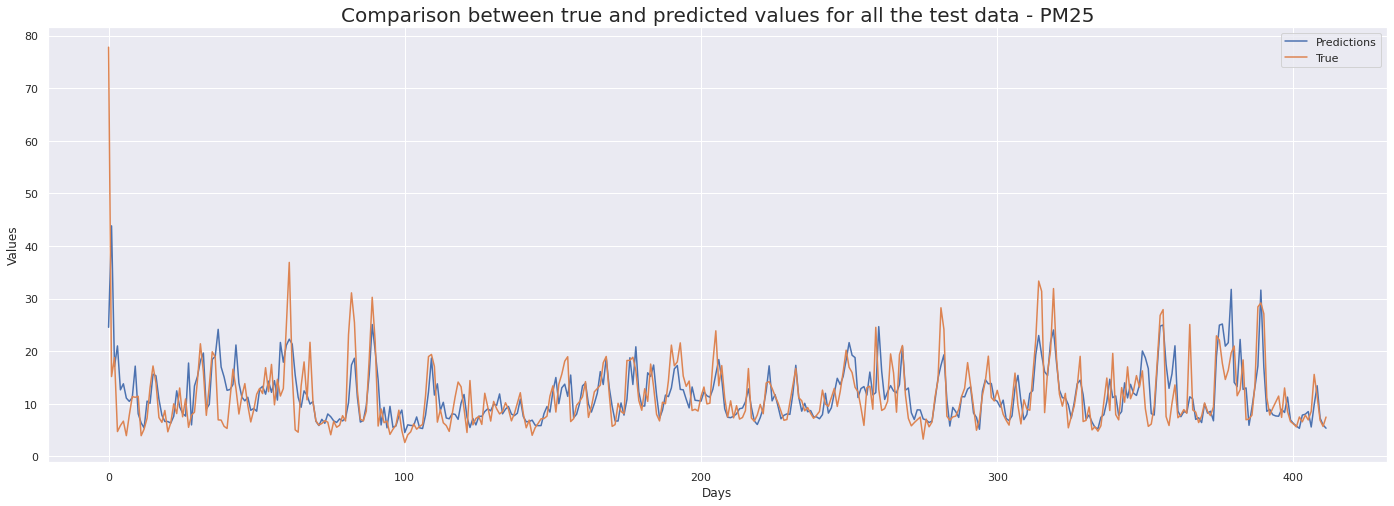

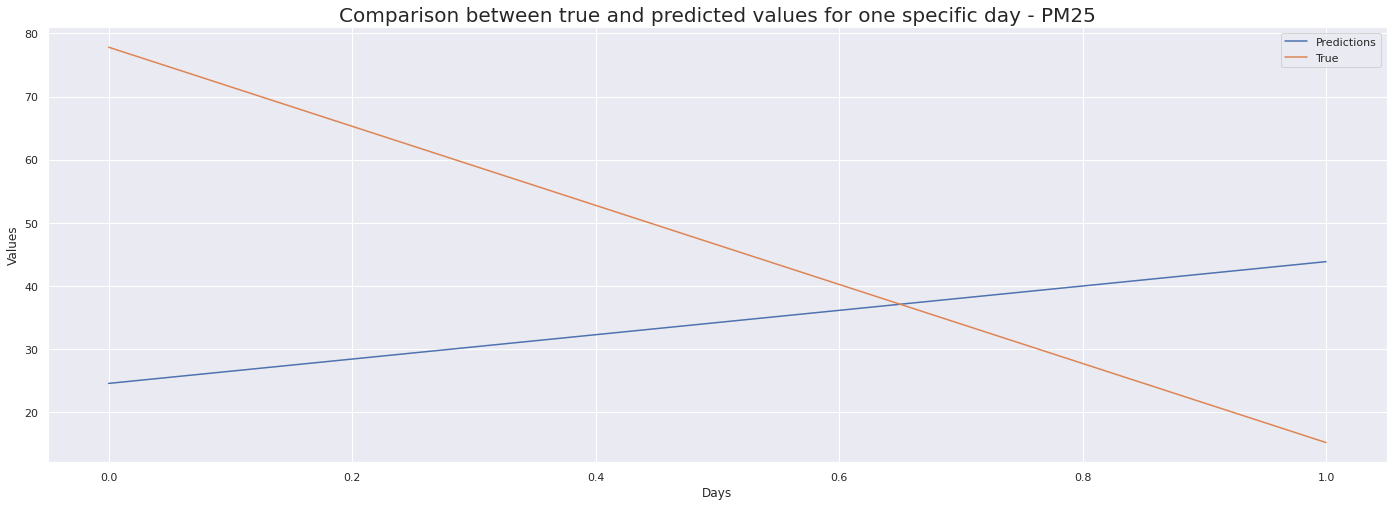

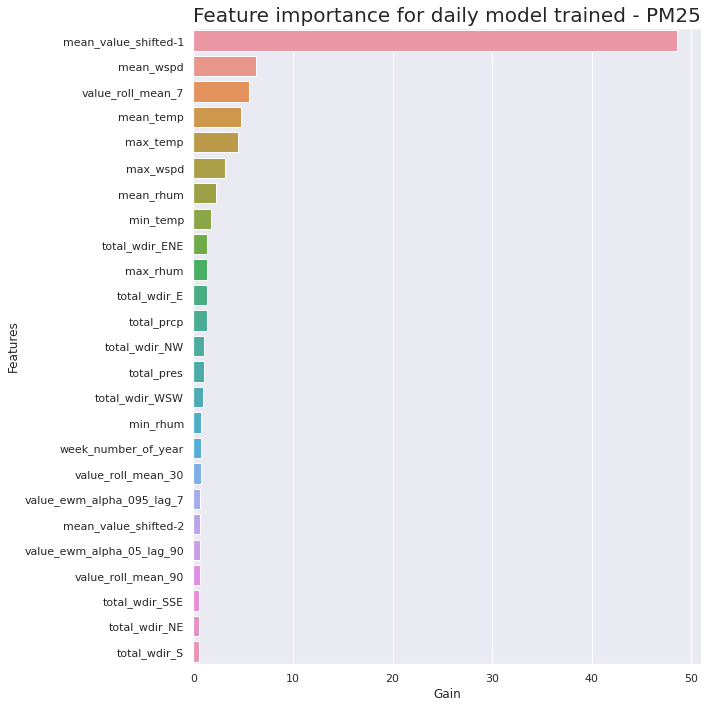

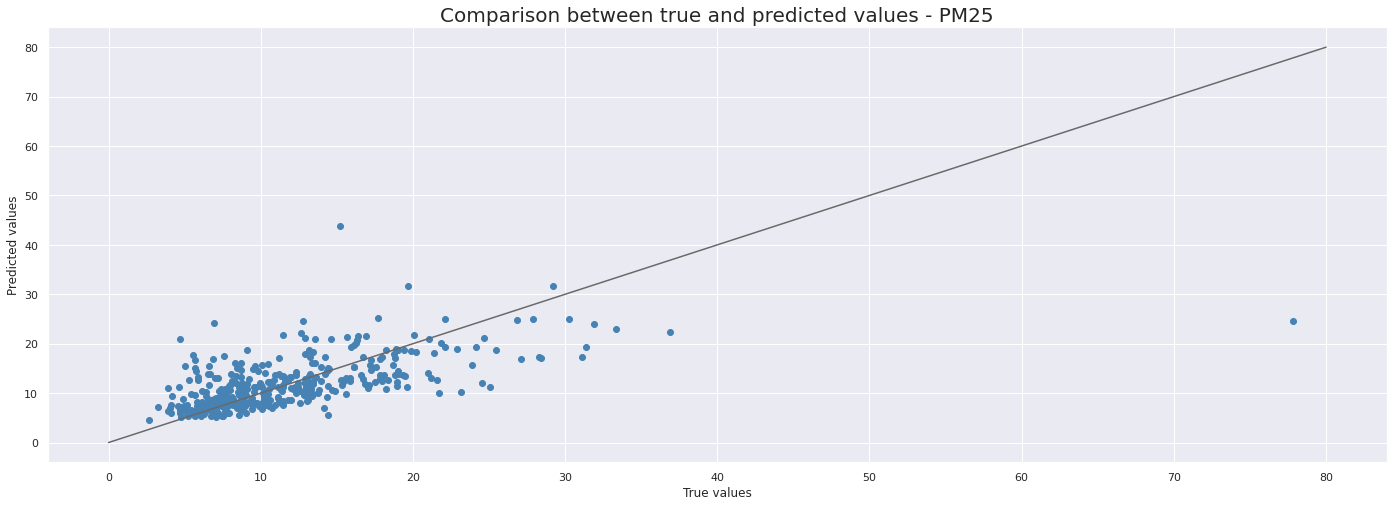

In [25]:
components = ["NO2", "PM10", "PM25"]
df_type = "daily"

aq_daily = aq.copy()

# data engineering
df = transform_data(aq_daily)
df_aggr_day = create_aggr_daily_df(df)

# train/evaluate
for comp in components:
    train, val, test = transform_data_for_comp(df_aggr_day, comp, df_type)

    Y_train = train['mean_value']
    X_train = train.drop(['date', 'std_value', 'min_value', 'max_value', 'mean_value'], axis=1)

    Y_val = val['mean_value']
    X_val = val.drop(['date', 'std_value', 'min_value', 'max_value', 'mean_value'], axis=1)

    Y_test = test['mean_value']
    X_test = test.drop(['date', 'std_value', 'min_value', 'max_value', 'mean_value'], axis=1)

    model = train_model_lgb(X_train, Y_train, X_val, Y_val)
    metrics = eval_model(model, X_test, Y_test)
    #pd.DataFrame(metrics[2], columns=['predictions']).to_csv(f'results/{df_type}/{df_type}_predsLGBM_{comp}.csv', sep=",")

    #save_error_results(metrics, df_type)
    
    print('MAPE', comp, 'equal to', metrics[1])
    
    plot_images(model, metrics[2], Y_test, comp, df_type);

Looking at the 3 daily LightGBM models, the most important feature is still the previous average value but then we see that weather elements come into play, which we had not seen so pronounced in the hourly models.

Next, we present the results of the MAPE errors for all the models considered:

In [26]:
#define header names
col_names = ["Component", "LightGBM", "Holt-Winters", "SARIMA"]

print('Hourly Models MAPE (%)')

#Results table
data_hourly = [["NO2", 16.71, 17.34, '-'], 
               ["PM10", 19.78, 36.43, '-'], 
               ["PM25", 20.38, 33.52, '-']]

#display table
print(tabulate(data_hourly, headers=col_names, tablefmt="fancy_grid"))

Hourly Models MAPE (%)
╒═════════════╤════════════╤════════════════╤══════════╕
│ Component   │   LightGBM │   Holt-Winters │ SARIMA   │
╞═════════════╪════════════╪════════════════╪══════════╡
│ NO2         │      16.71 │          17.34 │ -        │
├─────────────┼────────────┼────────────────┼──────────┤
│ PM10        │      19.78 │          36.43 │ -        │
├─────────────┼────────────┼────────────────┼──────────┤
│ PM25        │      20.38 │          33.52 │ -        │
╘═════════════╧════════════╧════════════════╧══════════╛


In [27]:
print('Daily Models MAPE (%)')
#Results table
data_daily = [["NO2", 16.41, 31.25, 28.41], 
              ["PM10", 22.89, 30.87, 36.92], 
              ["PM25", 25.85, 40.05, 28.94]]
  
#display table
print(tabulate(data_daily, headers=col_names, tablefmt="fancy_grid"))

Daily Models MAPE (%)
╒═════════════╤════════════╤════════════════╤══════════╕
│ Component   │   LightGBM │   Holt-Winters │   SARIMA │
╞═════════════╪════════════╪════════════════╪══════════╡
│ NO2         │      16.41 │          31.25 │    28.41 │
├─────────────┼────────────┼────────────────┼──────────┤
│ PM10        │      22.89 │          30.87 │    36.92 │
├─────────────┼────────────┼────────────────┼──────────┤
│ PM25        │      25.85 │          40.05 │    28.94 │
╘═════════════╧════════════╧════════════════╧══════════╛


In the next section, we will present a working model of the final product, based on the hourly predicted values.

## 🖼️ Visualisations


Here are some examples of the final product (based on hourly forecast). The main idea is to present a Power BI dashboard with predictions of air quality for the upcoming 7 days. This would require weather predictions for a specific future week, but could be fully integrated. It can also be used to assess the impact of measures taken by comparison with the historical data provided.

In this example we use predictions for the final week of data of our dataset.

The dashboard can be fully adapted to the needs of the policy makers and we expect for it to be used to take decisions such as:

- for days/periods with unhealthy air pollution levels, traffic can be closed or curbed; warnings can be issued to discourage people to frequent the street while the pollution levels remain high.
- for days/periods with healthy air pollution levels, green modes of transportation can be encouraged, public fairs and activities can be organized to attract people to Stadhouderskade.

With the implementation of these measures, we hope to bring positive changes to the lifestyle of Stadhouderskade, increasing people's confidence in being able to spend time there, with lower concerns in regards to their health.

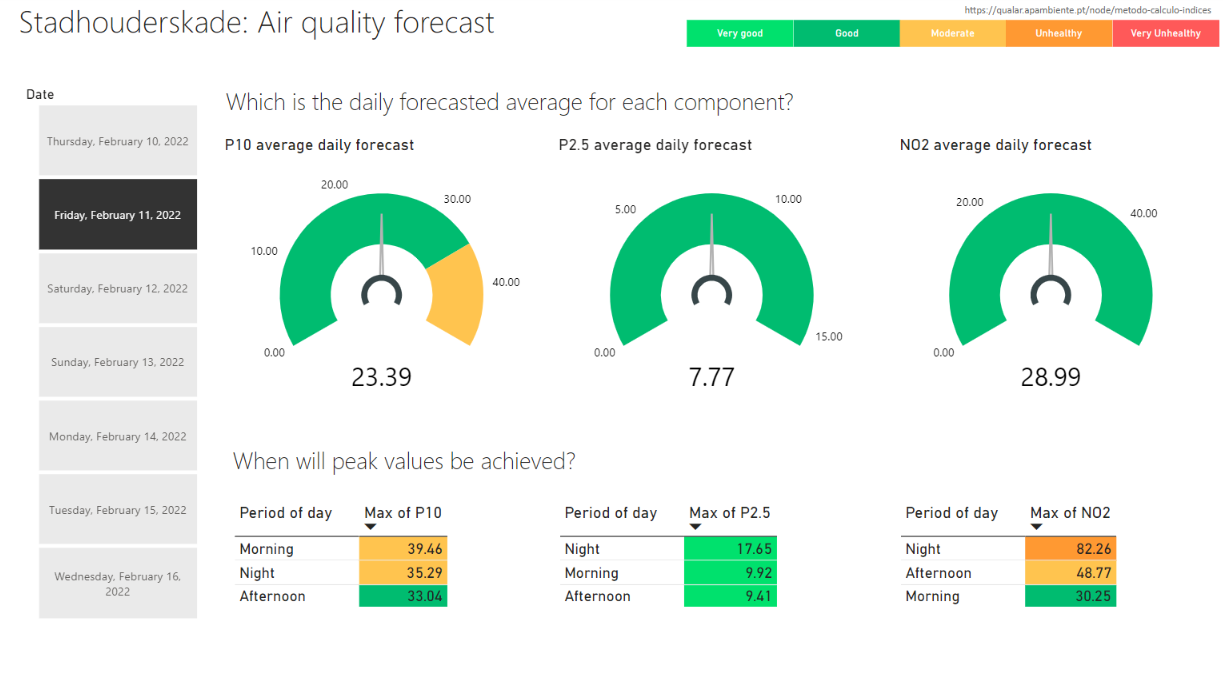

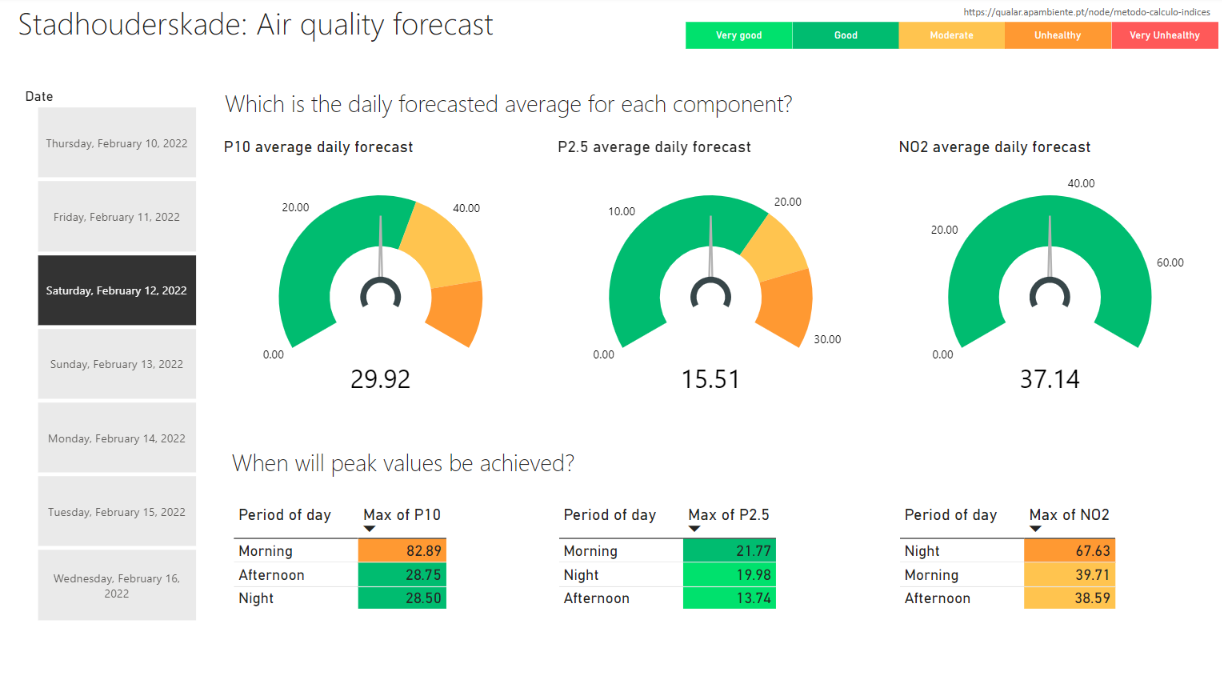

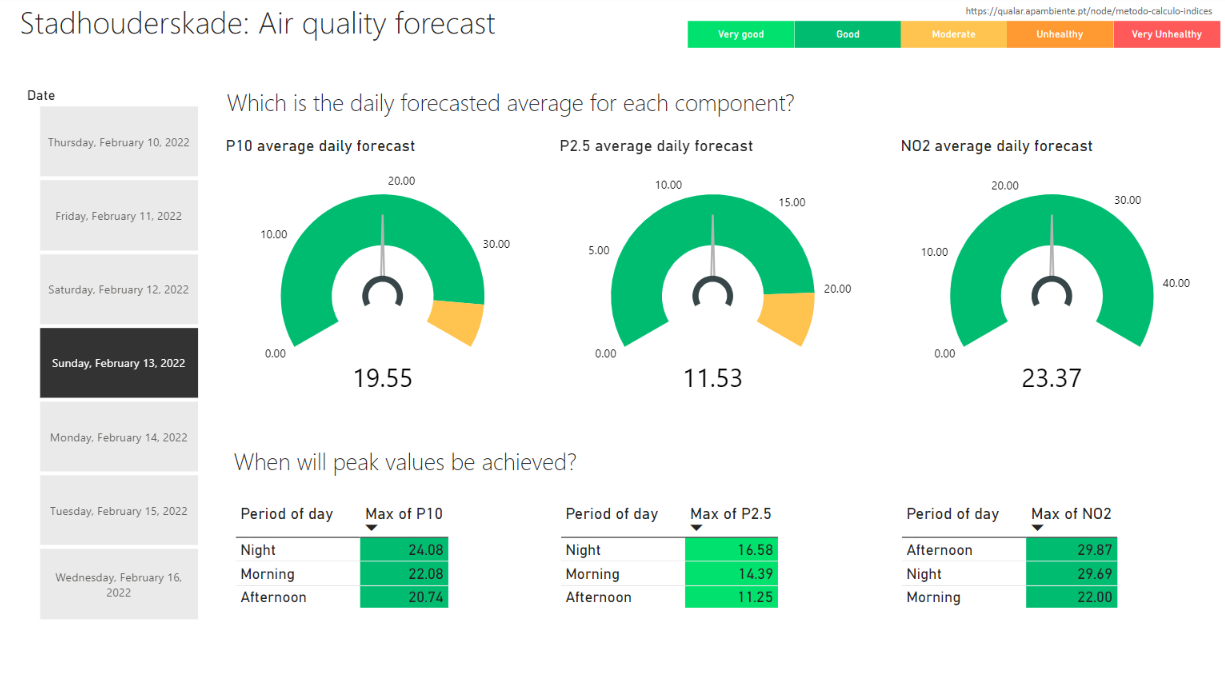

## 👓 References
List all of the external links (even if they are already linked above), such as external datasets, papers, blog posts, code repositories and any other materials.

 - Meteostat weather data
 - "Predicting air pollution level in a specific city" by Dan Wei
 - "Implementation of Machine Learning Algorithms for Analysis and Prediction of Air Quality" by Dyuthi Sanjeev
 - "Analysis and Prediction of Air Quality" by Reshma J
 - "Air quality assessment and pollution forecasting using artificial neural networks in Metropolitan Lima‑Peru" by Chardin Hoyos Cordova, Manuel Niño Lopez Portocarrero, Rodrigo Salas, Romina Torres, Paulo Canas Rodrigues & Javier Linkolk López‑Gonzales
 - "Air Quality Index Prediction and Classification" by Ardra Nandakumar, Jasmine Jose
 - "Analysis and prediction of air quality in Nanjing from autumn 2018 to summer 2019 using PCR–SVR–ARMA combined model" by Bing Liu, Yueqian Jin & Chaoyang Li
 

## ⏭️ Appendix
Add here any code, images or text that you still find relevant, but that was too long to include in the main report. This section is optional.


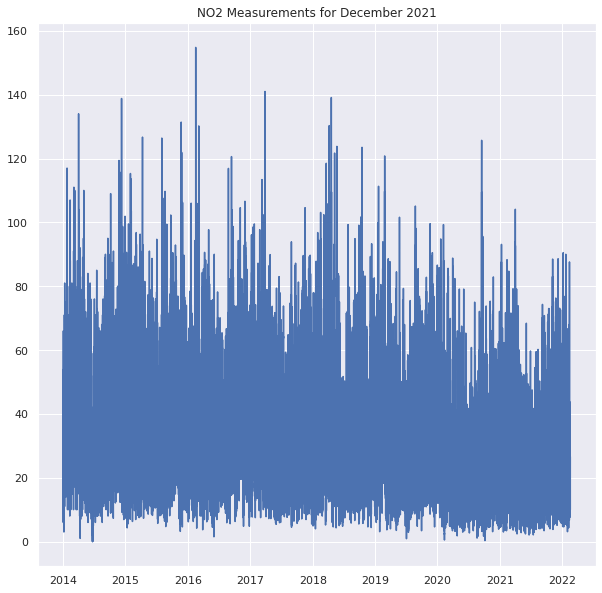

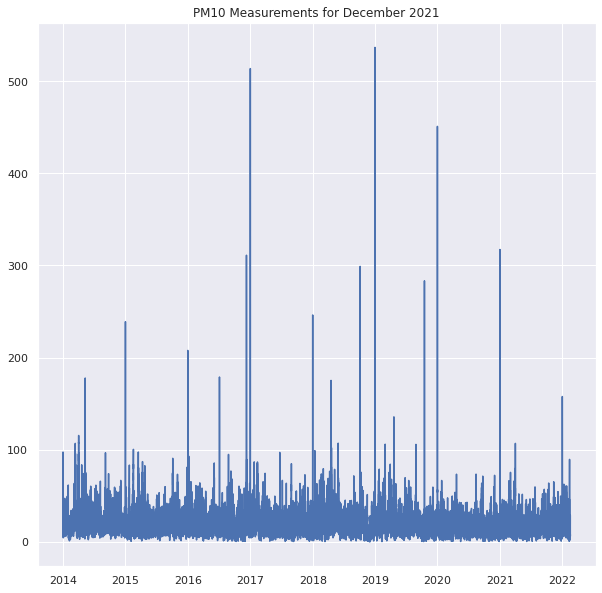

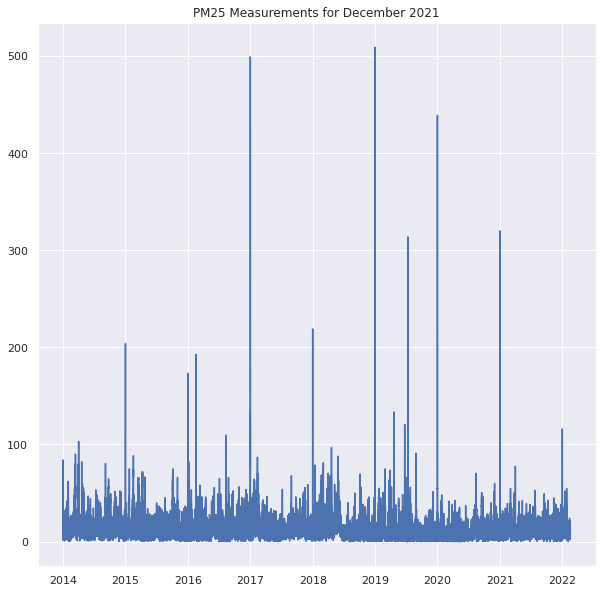

In [28]:
# Plot of measurements for PM2.5, PM10 and NO2 for the whole period.

for comp in aq.component_id.unique():
    plt.figure(figsize=(10,10))
    plt.plot(aq[(aq['component_id'] == comp)].timestamp_measured, aq[(aq['component_id'] == comp)].value)
    title = comp + ' Measurements for December 2021'
    plt.title(title)
    plt.show()

Time Series Analysis for stationarity and autocorrelation

All hypothesis testing were able to say, with 95% confidence, that the time series are not stationary.

NO2 

ADF Statistic: -20.777350
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Reject HO - Time Series is Stationary 

ADF Statistic: -49.077173
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Reject HO - Time Series is Stationary 



<Figure size 720x720 with 0 Axes>

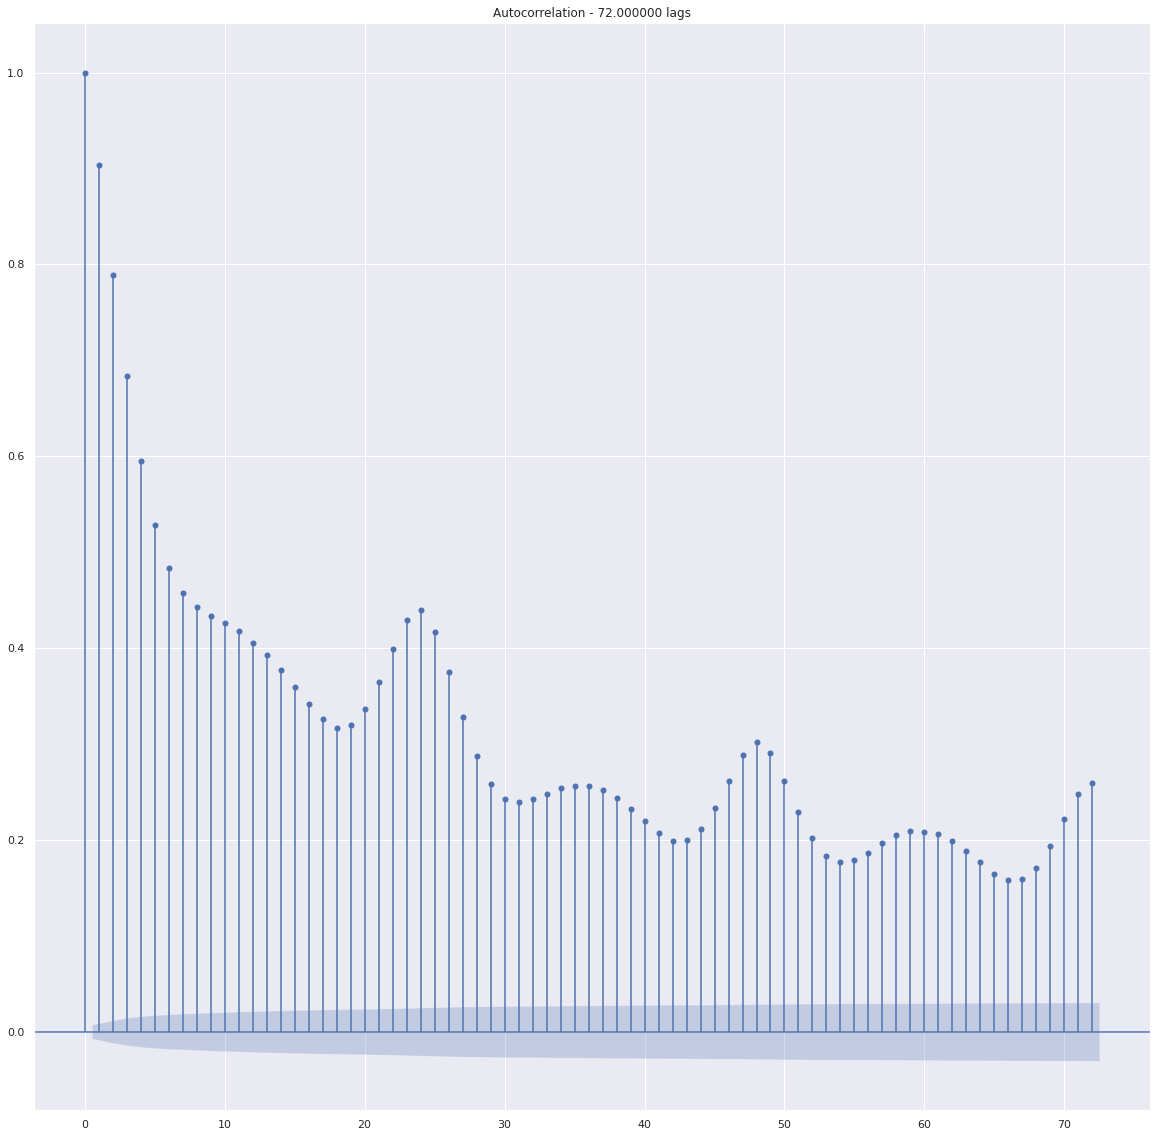

<Figure size 720x720 with 0 Axes>

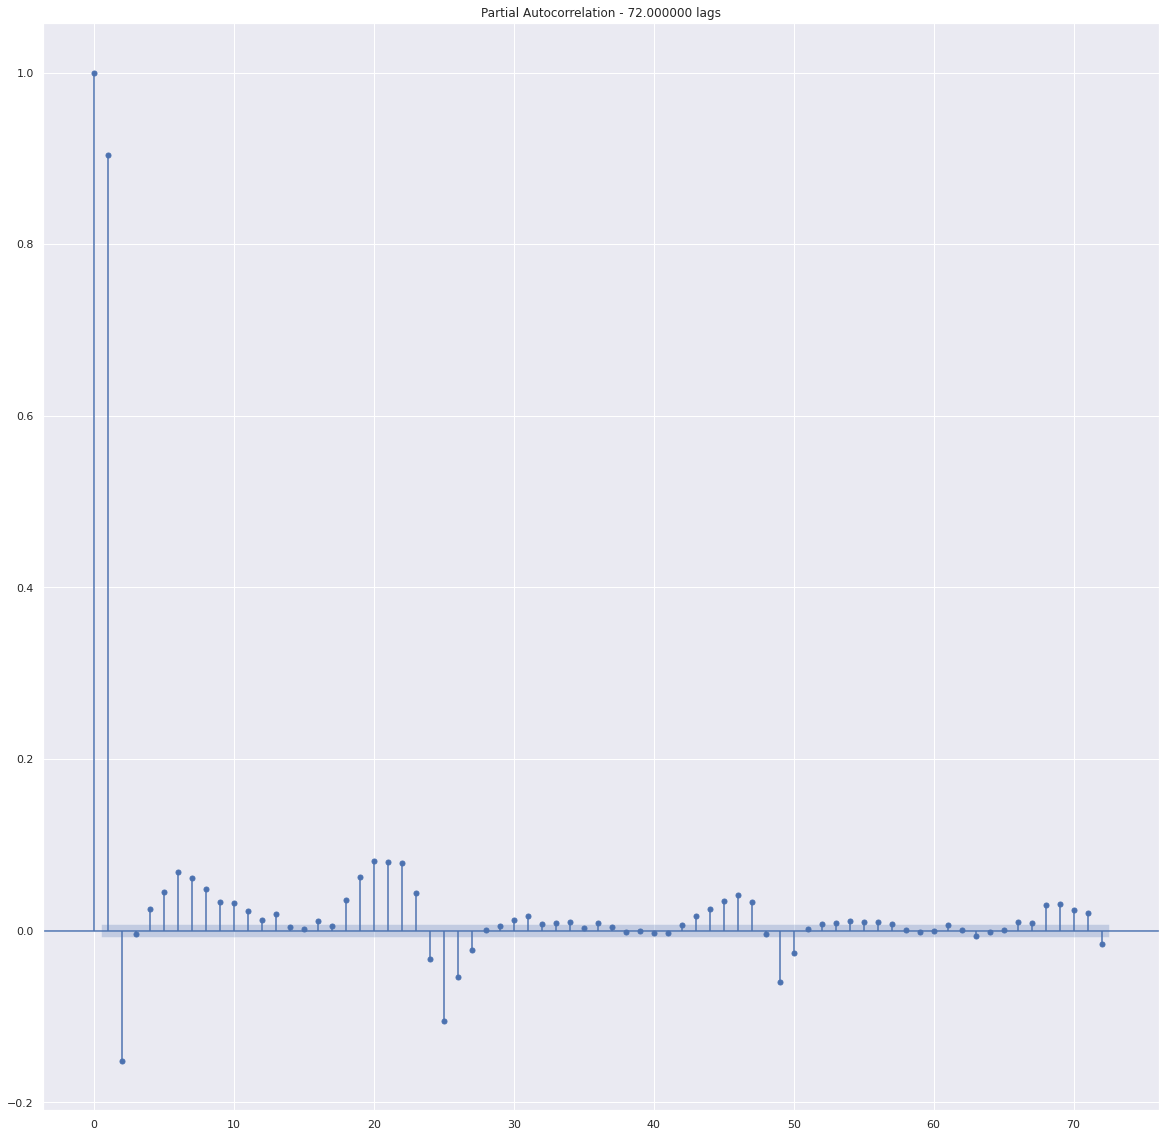

<Figure size 720x720 with 0 Axes>

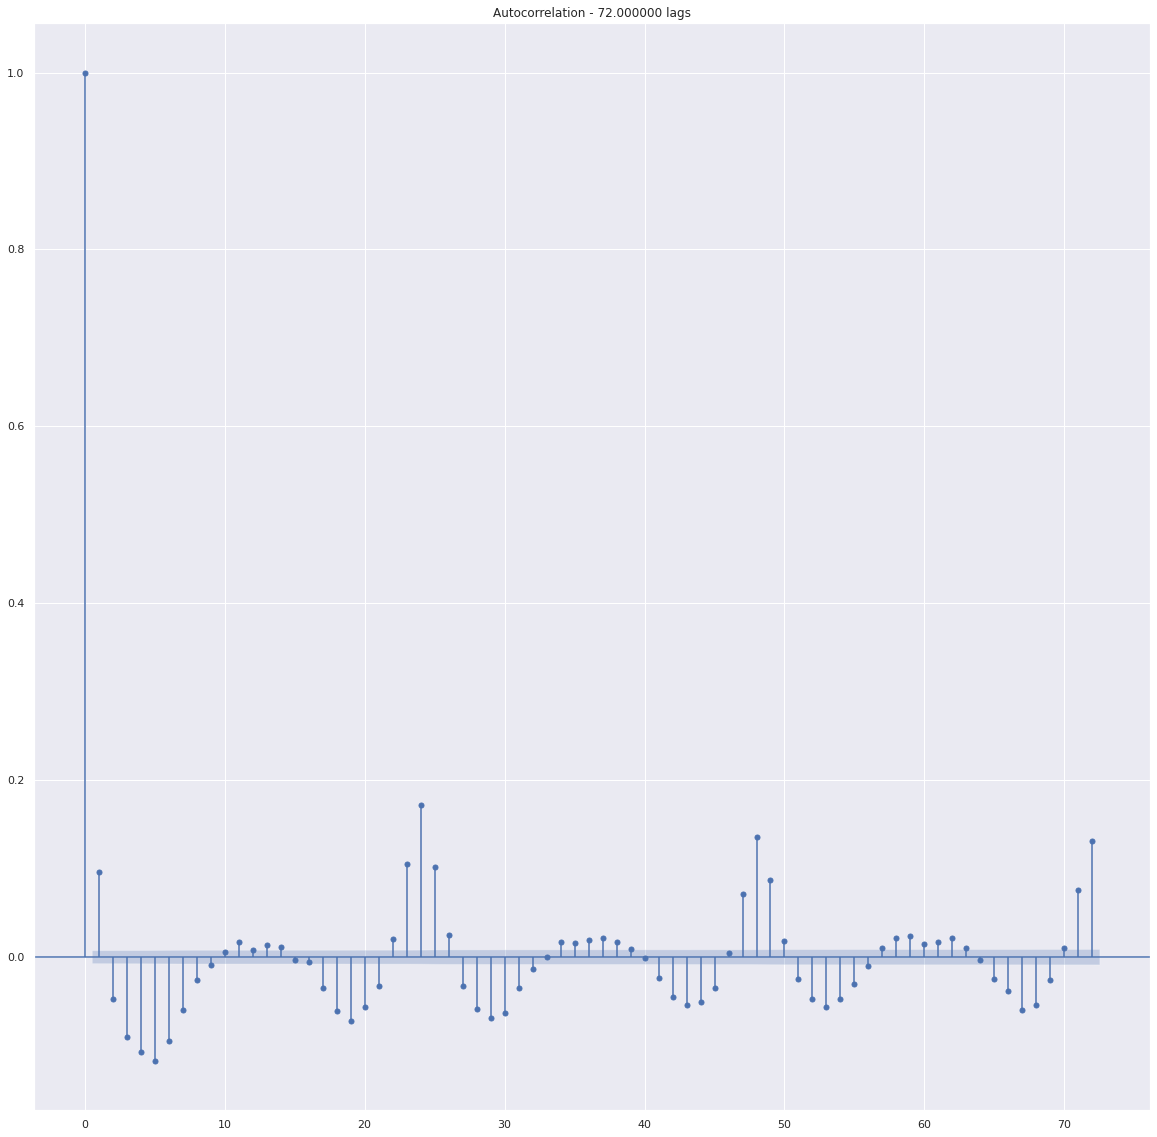

<Figure size 720x720 with 0 Axes>

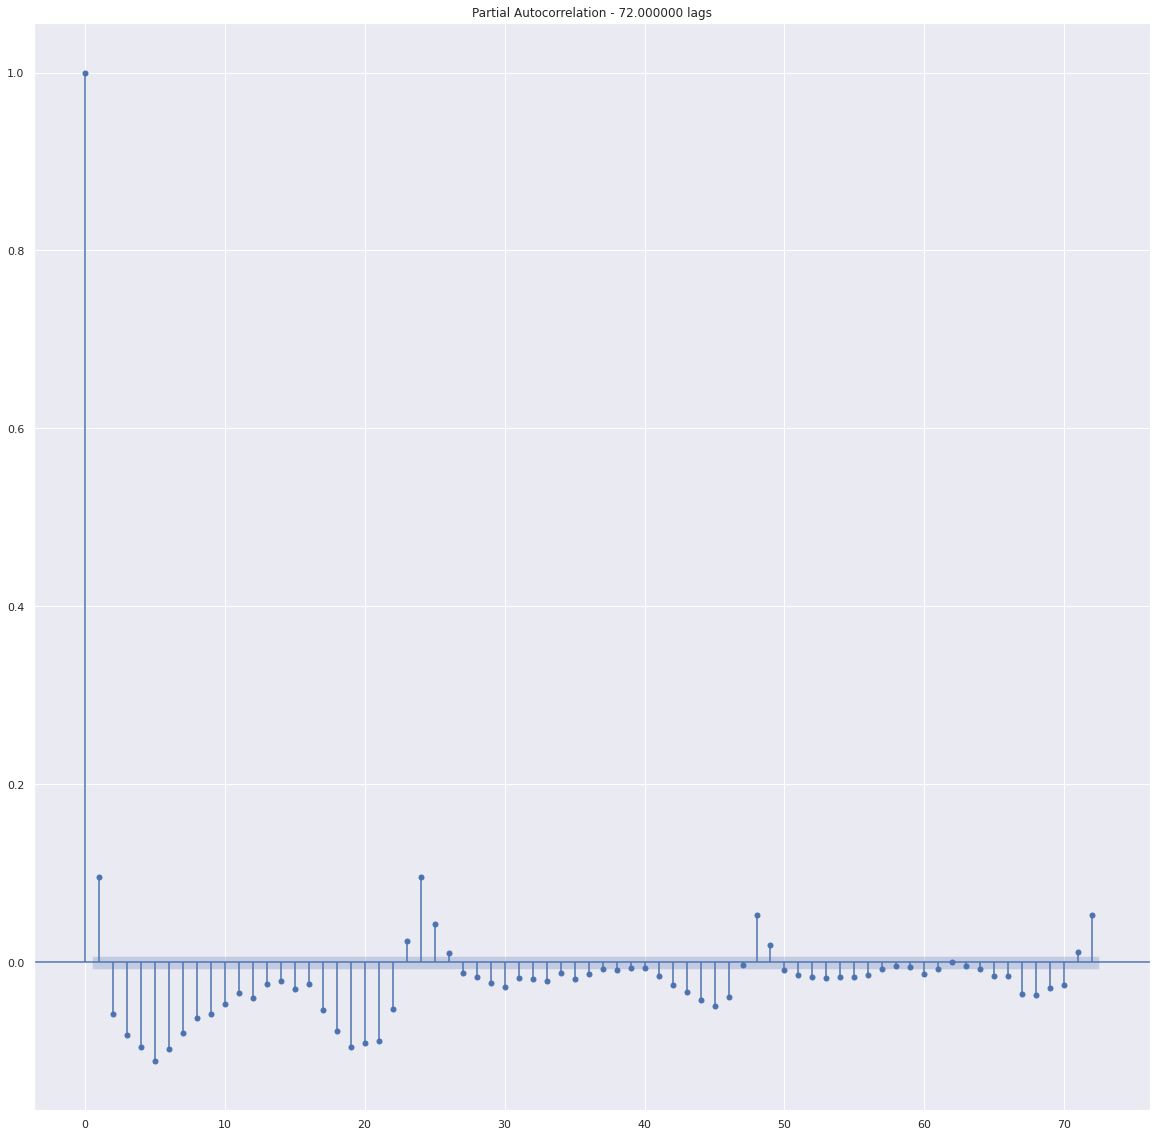

PM10 

ADF Statistic: -23.146383
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Reject HO - Time Series is Stationary 

ADF Statistic: -47.441292
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Reject HO - Time Series is Stationary 



<Figure size 720x720 with 0 Axes>

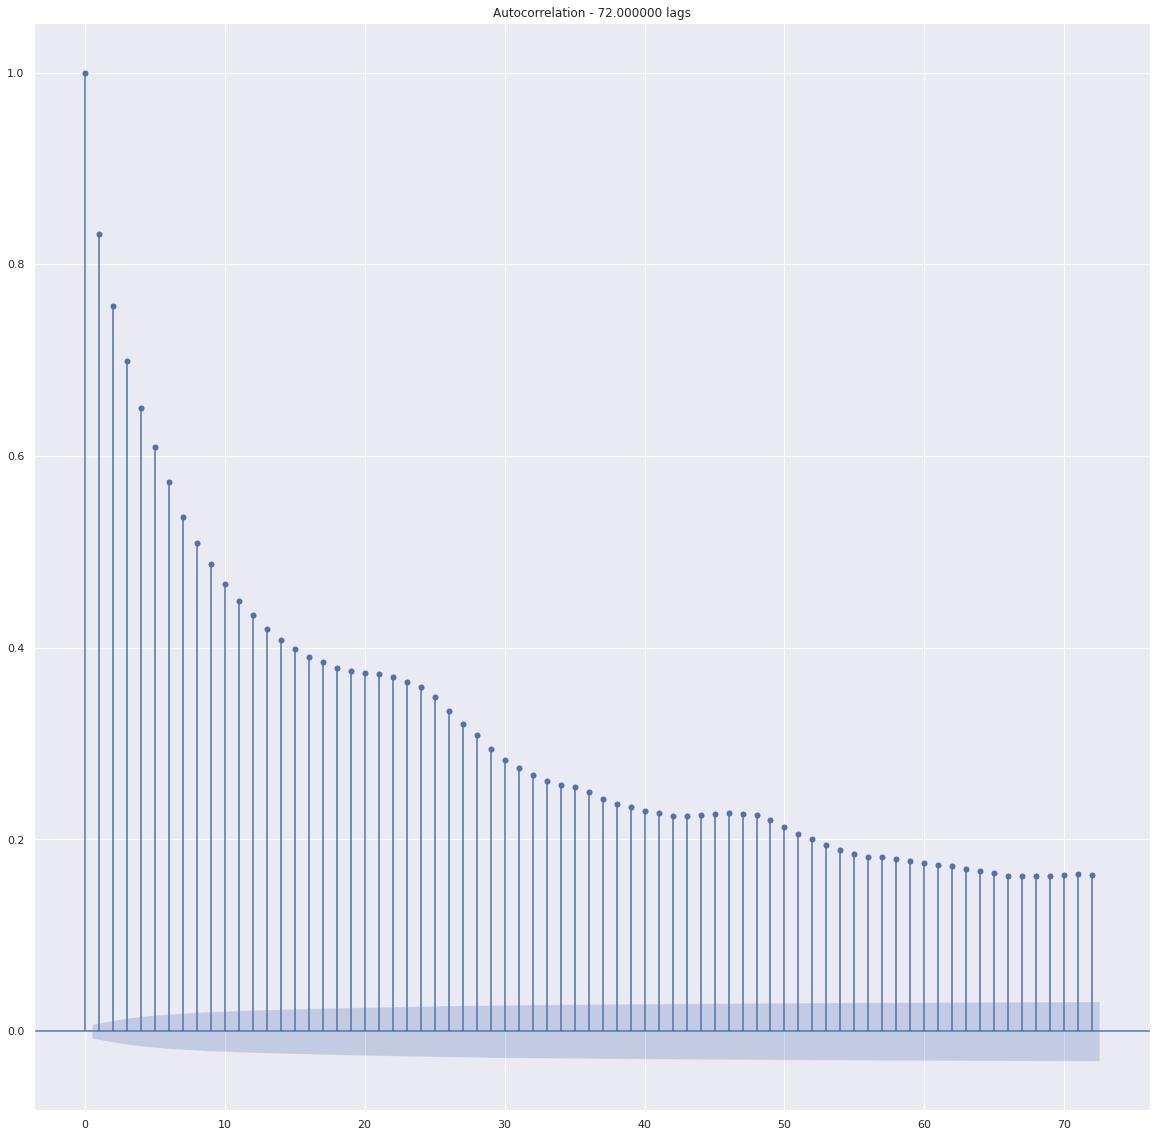

<Figure size 720x720 with 0 Axes>

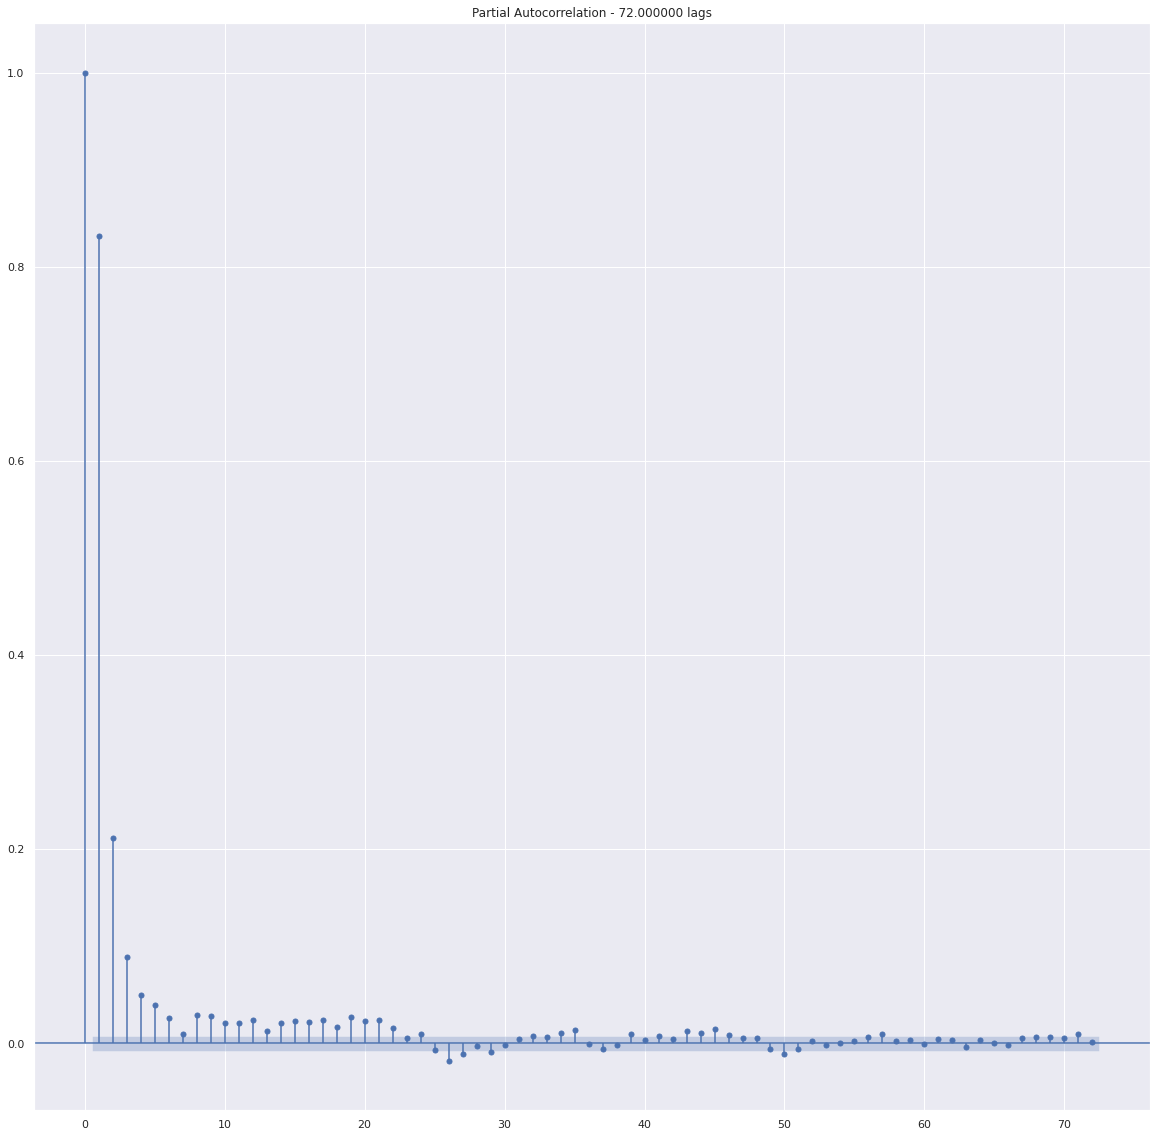

<Figure size 720x720 with 0 Axes>

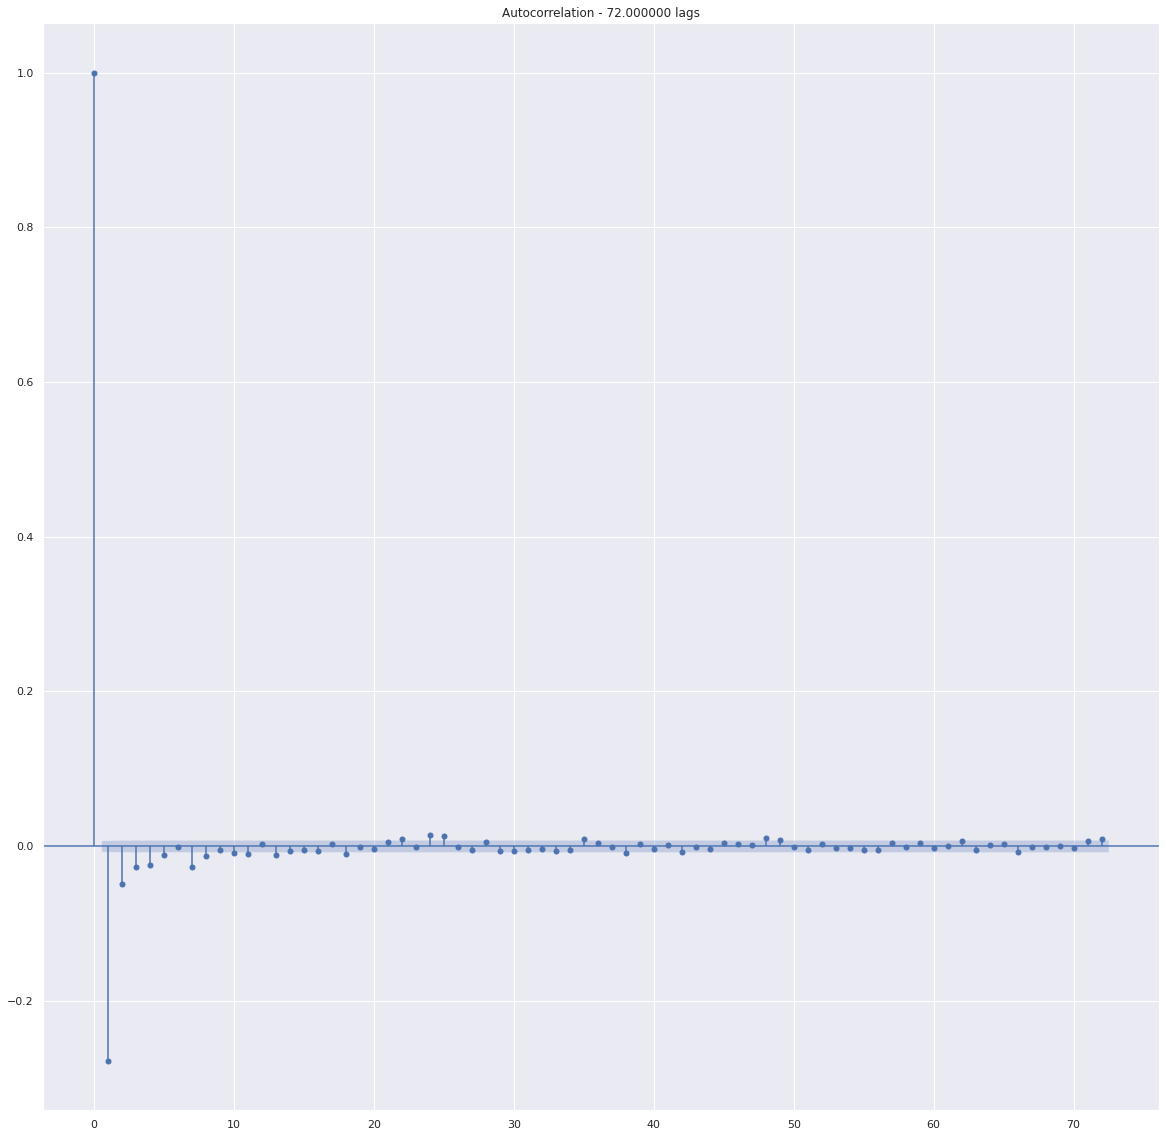

<Figure size 720x720 with 0 Axes>

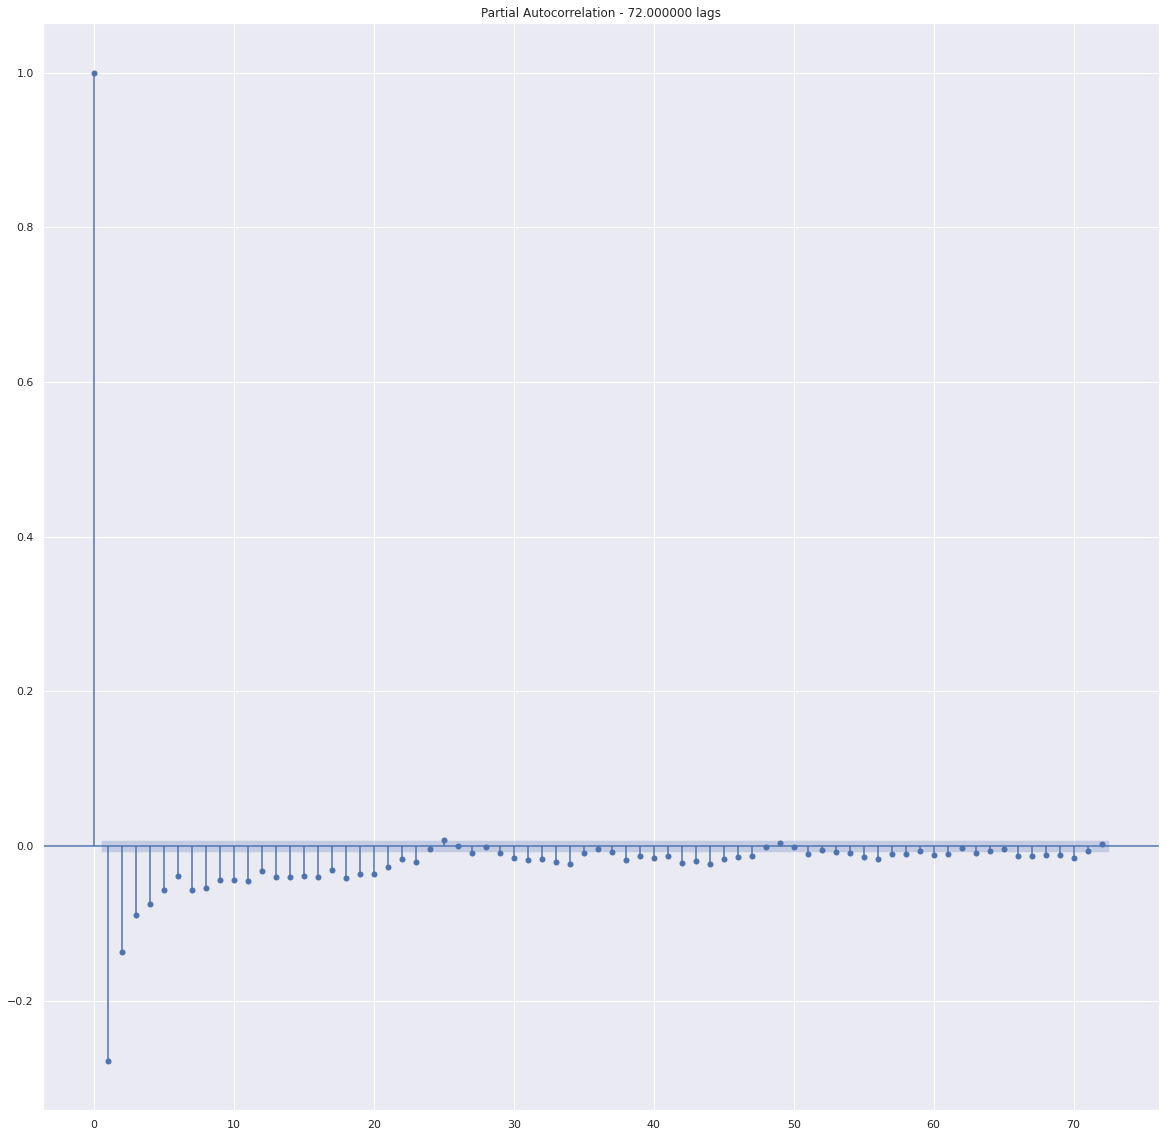

PM25 

ADF Statistic: -21.482667
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Reject HO - Time Series is Stationary 

ADF Statistic: -46.810792
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Reject HO - Time Series is Stationary 



<Figure size 720x720 with 0 Axes>

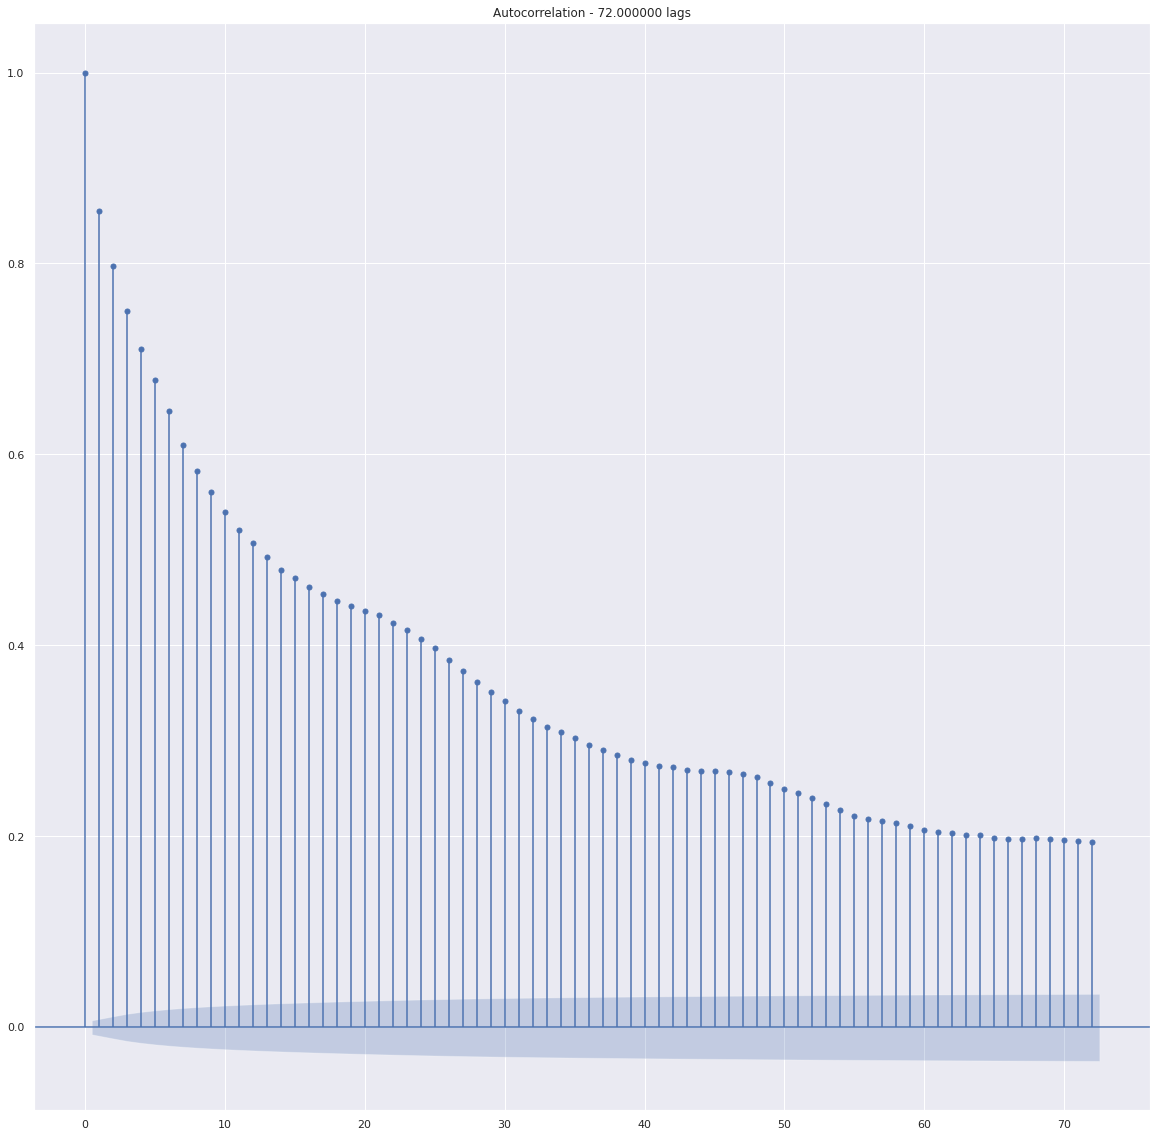

<Figure size 720x720 with 0 Axes>

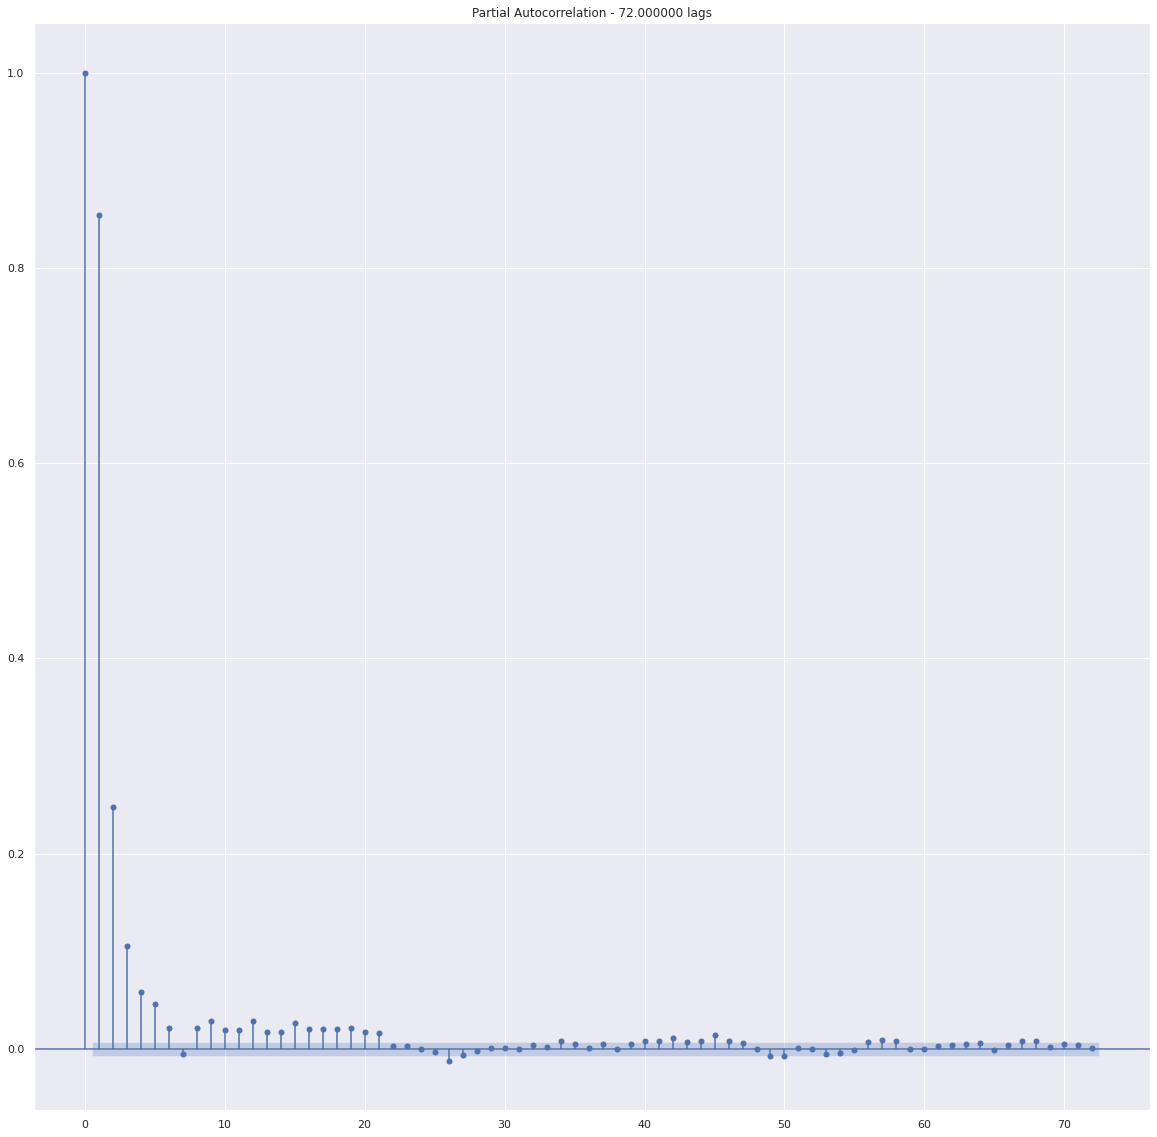

<Figure size 720x720 with 0 Axes>

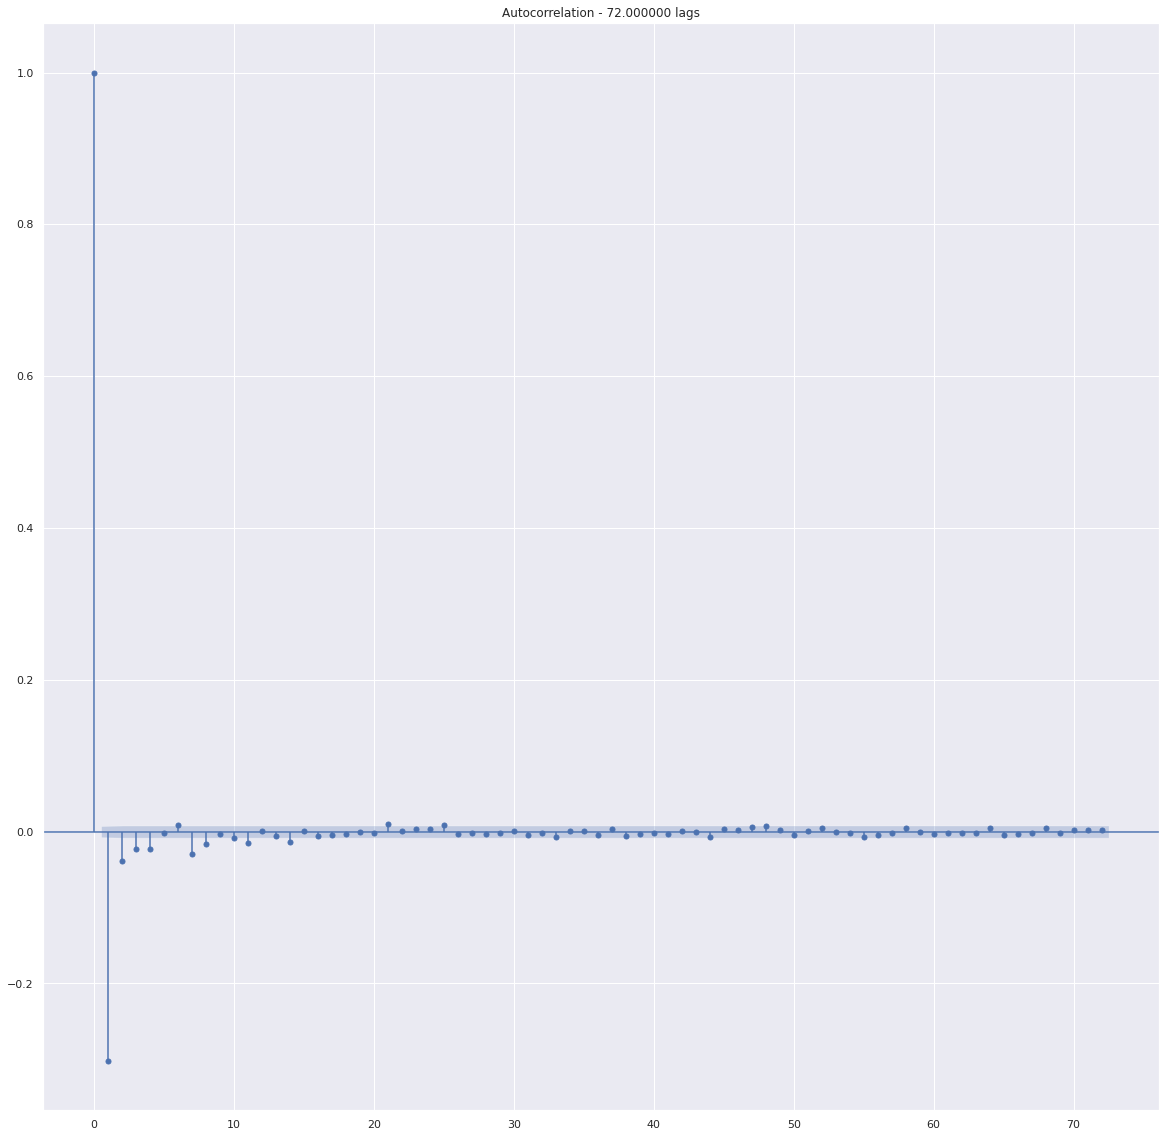

<Figure size 720x720 with 0 Axes>

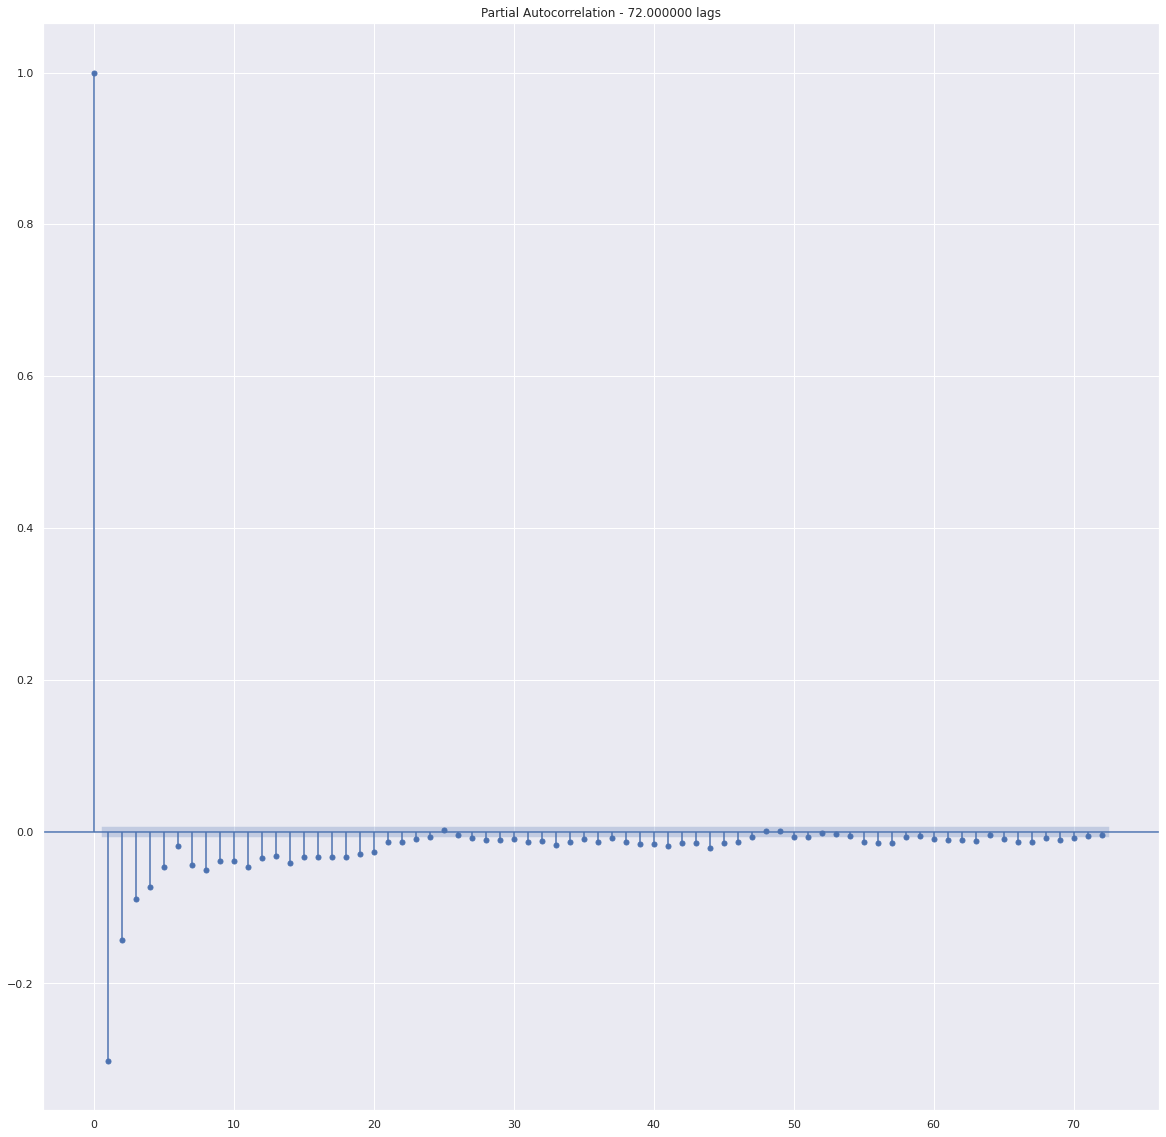

In [30]:
for comp in aq.component_id.unique():
    print(comp, "\n")
    X = aq[aq['component_id'] == comp]['value']
    Y = (aq[aq['component_id'] == comp]['value']-aq[aq['component_id'] == comp]['value'].shift(1))[1:]
    result = adfuller(X)
    result_dif = adfuller(Y)
    print('ADF Statistic: %f' % result [0])
    print('p-value: %f' % result [1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[0] < result[4]["5%"]:
        print("Reject HO - Time Series is Stationary \n")
    else:
        print("Failed to Reject HO - Time Series is Non-Stationary \n")

    print('ADF Statistic: %f' % result_dif [0])
    print('p-value: %f' % result_dif [1])
    print('Critical Values:')
    for key, value in result_dif[4].items():
        print('\t%s: %.3f' % (key, value))

    if result_dif[0] < result_dif[4]["5%"]:
        print("Reject HO - Time Series is Stationary \n")
    else:
        print("Failed to Reject HO - Time Series is Non-Stationary \n")

    k = 72
    plt.figure(figsize=(10,10))
    plot_acf(X, lags = k, title = 'Autocorrelation - %f lags' %k)
    plt.show()
    plt.figure(figsize=(10,10))
    plot_pacf(X, lags = k, title = 'Partial Autocorrelation - %f lags' %k)
    plt.show()
    plt.figure(figsize=(10,10))
    plot_acf(Y, lags = k, title = 'Autocorrelation - %f lags' %k)
    plt.show()
    plt.figure(figsize=(10,10))
    plot_pacf(Y, lags = k, title = 'Partial Autocorrelation - %f lags' %k)
    plt.show()